# Analyse des commentaires
Dans ce notebook, nous allons regarder en détail les commentaires laissés par les utilisateurs.
Le travail sera divisé en deux parties : Construction du corpus et Début ? d'analyse des fréquences

In [ ]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import NMF, Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from itertools import product
from scipy import sparse

from reco_systems.filter import filter_df
import reco_systems.evaluation_bigrams_func as bev
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *
from reco_systems.lemmatization import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


#### Functions

In [2]:
def words_freq(data, corpus) -> pd.DataFrame:
    """
    Construction d'un dataframe avec la fréquence des mots dans un corpus
    """

    lem, occurences = np.unique(data['Lemma'], return_counts=True)

    df = pd.DataFrame({'Lemma': lem, 'Freq': occurences})
    nb_comments = data["Comment line"].nunique()
    df['Freq'] = df['Freq'].apply(lambda val: val/nb_comments)

    # Garder uniquement les lemmas qui appraissent dans le corpus
    #return df[df['Lemma'].isin(corpus)]
    return df

def construction_corpus(lemmas:pd.DataFrame, taille: int) -> dict:
    """ 
    Construction d'un corpus à partir d'une BDD de commentaires
    avis.colums = 'Comment title', 'Comment body'

    Retourne df avec mots du corpus et leurs fréquences, les 'taille' plus fréquentes
    """

    # Corpus creation from lemmatized dataframe
    lemmas = lemmas[~lemmas["Lemma"].isna()]
    lemmas = lemmas[lemmas['Part of speech'].isin(['ADJ', 'NOM', "VER", "NEG"])]
    lemmas = lemmas[~lemmas["Lemma"].isin(["bref", "bof", "excelent", "bon", "autre", "seul", "tendre", "fin"
                                           "super", "superbe", "juste", "jouable", "ca", "faire", "pouvoir", "ausi"])]
    lemmas = lemmas['Lemma'].to_numpy()

    # Occurencies calculation for each lemma
    lem, occ = np.unique(lemmas, return_counts=True)
    freq_lem = pd.DataFrame({'lemma': lem, 'freq': occ})

    freq_lem = freq_lem.sort_values(by=['freq'], ascending=False)
    return freq_lem.head(taille)['lemma'].to_numpy()

#### Data

In [162]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=np.arange(0, rev_filter.shape[0]))
rev_filter_center, _= center_score(rev_filter)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [164]:
rev_filter = rev_filter.reset_index()

### Corpus 5000 mots

In [154]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
corpus = construction_corpus(lemmas, 5000) 
lemmas = lemmas[lemmas["Lemma"].isin(corpus)] # only words in corpus

# Joined lemmas
comments = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})

In [155]:
com = rev_filter[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
com = com.groupby(["Game id", "User id", "Comment line"])["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})

### NMF 20 latent factors

In [6]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]

### 30 KMeans games clusters 

In [7]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id" : np.sort(games_ids), "Cluster" : kmeans.labels_})

In [8]:
# Séparation de la bdd 
positifs = rev_filter_center[rev_filter_center['Rating'] >= 0]
negatifs = rev_filter_center[rev_filter_center['Rating'] < 0]

print("Nombre d'avis negatif", len(negatifs)/len(rev_filter_center))
print("Nombre d'avis positif", len(positifs)/len(rev_filter_center))

Nombre d'avis negatif 0.43073353153843763
Nombre d'avis positif 0.5692664684615624


In [171]:
fuck[(fuck['User id'] == 201) & (fuck['Game id'] == 10409)]

,Comment line,Game id,User id,Comment
24647,39079,10409,201,de zombie dice petit jeu stop pretention grand...


In [169]:
fuck = rev_filter[["Game id", "User id", "level_0"]].merge(lemmas, right_on="Comment line", left_on="level_0")
fuck = fuck.groupby(["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})

In [ ]:
c = rev_filter[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
c = c.groupby(["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})

In [139]:
c[(c["User id"]==201) & (c["Game id"]==10409)]

,Comment line,Game id,User id,Comment
15499,25045,10409,201,viking expedition de cela joli emballage incar...


In [137]:
rev_filter[(rev_filter["User id"] == 201) & (rev_filter["Game id"] == 10409)]

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body,index
39079,10409,201,Zombie Dice Deluxe,Gigi,2011-04-18 12:29:00,4.0,Dés cérébrés !,Zombie Dice est un petit jeu de stop ou encore...,25045


In [11]:
# filter rev filter that is in c, filtered lemma by corpus

filtered_rev_df = rev_filter.merge(c, on=["Game id", "User id"], how="inner")

In [12]:
filtered_rev_df[(filtered_rev_df["Game id"] == 6) & (filtered_rev_df["User id"] == 3380)]['Comment body'].values

array(["Le jeu est assez simple une carte dans le défausse (4 par exemple) soit a son tour on pose la meme carte soit on procede a une operation avec deux de ses cartes en incluant le 4 dans l'operation( addition ou soustraction) par exemple je defausse un de mes 2 et 6, car 2+4=6, soit on pioche, quand on n'as plus de cartes c'est la victoire, agrementer tous ça de cartes speciales pour faire des sales coup a vos collegues et je lui met un 4/5 pour cette bonne idée; surtout que pour les enfants c'est educatif..."],
      dtype=object)

In [13]:
lemmas_pos = positifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_neg = negatifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_pos = lemmas_pos.drop(["index"], axis=1)
lemmas_neg = lemmas_neg.drop(["index"], axis=1)

lemmas_all = rev_filter[["User id", "Game id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_all = lemmas_all.drop(["index"], axis=1)

In [14]:
comments_neg = lemmas_neg.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_neg = comments_neg.assign(pos_neg = "negative")

comments_pos = lemmas_pos.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_pos = comments_pos.assign(pos_neg = "positive")

comments_all = pd.concat([comments_neg, comments_pos])
comments_all_count = comments_all[["Game id", "pos_neg", "User id"]].groupby(["Game id", "pos_neg"]).count().rename(columns={"User id":"count"}).reset_index()

In [15]:
# filters user id that have at least 10 reviews

count_us = comments_all[["User id", "Lemma"]].groupby("User id").count().sort_values(ascending=False, by='Lemma')
users_keeps = count_us[count_us['Lemma'] >= 10].index
users_keeps

Index([ 208,   83,    1,   91,  201, 1724, 1936, 2747, 1998, 1191,
       ...
       4045, 2552, 7454, 2379,  718, 7491, 6073, 2697, 7489, 3412],
      dtype='int64', name='User id', length=1448)

In [16]:
comments_all = comments_all[comments_all['User id'].isin(users_keeps)]
comments_all = comments_all.sort_values(by=['Game id', 'User id']).reset_index(drop=True)
comments_all

,Comment line,Game id,User id,Lemma,pos_neg
0,54884,6,3380,regle qualite auto interessant pioche semi boi...,negative
1,54886,6,5517,si cela petit jeu carte apparence cache gamepl...,negative
2,54885,6,6948,falloir fier regle vf tres traduire demarrer p...,negative
3,19459,15,1,meilleur jeu temps effrayer certain joueur aga...,negative
4,19471,15,20,coup jeu hyper fun jubilatoire tres calculatoi...,negative
...,...,...,...,...,...
60799,43418,10546,4642,jeu bluff jeu bluff rapprocher perudo poker me...,positive
60800,43428,10546,5349,simple sympa petit jeu aimer bien sortir temps...,negative
60801,43424,10546,6306,glisse si aimer jeu perudo dernier naitre pens...,positive
60802,43419,10546,6595,neuf serieux pur jeu bluff si aimer genre alle...,negative


In [17]:
filtered_rev_df[filtered_rev_df["User id"]== 0][['Comment body', 'Comment']].head(1).values

array([["Lorsque le jeu est jeu, bon, réflexif, joli pour qui est sensible à ce style d'illustration... Lorsque l'on a envie d'y rejouer encore pour essayer autrement, et revivre cette histoire de papillons et de voyages... Et lorsqu'en plus, au détour des règles, on s'intéresse également au propos et à la sensibilisation, légère comme les ailes du dit-papillons et pourtant aussi bien amené, alors effectivement, il y a là un très bon jeu, ludiquement parlant (et il est possible de s'arrêter là) mais également très bon pour l'ouverture des yeux des joueuses et joueurs au monde qui nous entoure... Ça, c'est deux fois bon !",
        'voyage aile papillon jeu jeu joli sensible style illustration envier rejouer essayer revivre histoire papillon voyage detour regle interesser egalement propos leger aile dire papillon bien amener tres jeu ludiquement parler possible arreter egalement tres ouverture oeil joueur joueur monde entourer cela fois']],
      dtype=object)

In [18]:
filtered_rev_df = filtered_rev_df[filtered_rev_df['User id'].isin(users_keeps)]
filtered_rev_df = filtered_rev_df.sort_values(by=['Game id', 'User id']).reset_index(drop=True)
filtered_rev_df

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body,index,Comment line,Comment
0,6,3380,"1, 2 Truie !",glen,2010-04-17 12:28:56,8.0,"Tres sympa et joli, une pensée a nuf nuf",Le jeu est assez simple une carte dans le défa...,54884,54884,regle qualite auto interessant pioche semi boi...
1,6,5517,"1, 2 Truie !",mutation,2010-08-22 12:28:57,6.0,qui jouera verat !,"Un bon petit jeu de défausse, très facile à co...",54886,54886,si cela petit jeu carte apparence cache gamepl...
2,6,6948,"1, 2 Truie !",Hérøn,2013-03-10 10:19:25,6.0,For kids only,Un petit jeu très facile d'accès à réserver au...,54885,54885,falloir fier regle vf tres traduire demarrer p...
3,15,1,10' to kill,morlockbob,2016-02-02 12:19:32,6.5,welcome in the jungle,Mon pote n'arrêtait pas de dire « c est comme ...,19459,19459,meilleur jeu temps effrayer certain joueur aga...
4,15,20,10' to kill,boardgameguix,2021-10-27 23:04:07,5.0,"Deduction, bluff, bagarre",Helas rien de mémorable même si le jeu et joli...,19471,19471,coup jeu hyper fun jubilatoire tres calculatoi...
...,...,...,...,...,...,...,...,...,...,...,...
60799,10546,4642,ごきぶりポーカー,luc,2005-04-19 12:28:39,8.0,simple et efficace,un tres bon jeu de bluff: 30s pour expliquer l...,43418,43418,jeu bluff jeu bluff rapprocher perudo poker me...
60800,10546,5349,ごきぶりポーカー,gizzmo82,2009-02-12 12:28:52,6.0,Donne-moi ce cafard ou je prends la mouche !,C'est un excellent jeu d'ambiance. Moi qui aim...,43428,43428,simple sympa petit jeu aimer bien sortir temps...
60801,10546,6306,ごきぶりポーカー,MrPatate,2005-03-14 12:28:38,8.0,bégon orange,Bug Bluff c'est terriblement éprouvant pour le...,43424,43424,glisse si aimer jeu perudo dernier naitre pens...
60802,10546,6595,ごきぶりポーカー,kilpaddle,2010-01-11 12:28:55,6.0,pas mal un bon petit jeu d'apéro,pas mal un bon petit jeu d'apéro la règle est ...,43419,43419,neuf serieux pur jeu bluff si aimer genre alle...


In [19]:
rev_neg_count = comments_neg["Game id"].value_counts().reset_index()
rev_pos_count = comments_pos["Game id"].value_counts().reset_index()

# Filter games so that each game has at least 10 pos and 10 neg reviews
games_preserved = rev_neg_count[rev_neg_count["Game id"].isin(rev_pos_count.loc[rev_pos_count["count"] >= 10, "Game id"])
                                & rev_neg_count["Game id"].isin(rev_neg_count.loc[rev_neg_count["count"] >= 10, "Game id"])]["Game id"].values
                                
mask = np.isin(np.sort(games_ids), games_preserved)

# Games clusters contains only games that were filtered
games_clusters = pd.DataFrame(data={"Game id":np.sort(games_ids)[mask], "Cluster":kmeans.labels_[mask]})

In [20]:
# Barplot the distribution of pos/neg comments
def plot_pos_neg_games(selected_games, comments_all_count, title, all=False):
    sns.set_theme(rc={"figure.figsize":(15, 6)})
    filtered = comments_all_count[comments_all_count["Game id"].isin(selected_games["Game id"])]
    if not all:
        filtered = filtered.head(50)
    ax = sns.barplot(data=filtered, x="Game id", y="count", hue="pos_neg", errorbar=None)
    ax.set_title(title)
    if all:
        ax.set(xticklabels=[])

def create_df(ngram_finder, ngram_stat):
        bigram_freq = ngram_finder.score_ngrams(ngram_stat)

        bigrams_df = pd.DataFrame(data=[list(info) for info in bigram_freq])
        bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
        bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})
        return bigrams_df

def get_Ngrams(game, ngram_finder, ngram_stat):
    comments_pos = lemmas_pos[lemmas_pos["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    comments_neg = lemmas_neg[lemmas_neg["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    
    #if comments_pos.size > 0:
    bigram_finder_pos = ngram_finder.from_documents(comments_pos)
    freq_pos = create_df(bigram_finder_pos, ngram_stat)
    #if comments_neg.size > 0:
    bigram_finder_neg = ngram_finder.from_documents(comments_neg)
    freq_neg = create_df(bigram_finder_neg, ngram_stat)
    
    diff_freq = ft.diff_freq(freq_pos, freq_neg)

    return freq_pos, freq_neg, diff_freq

def plot_games_Ngrams_freq_diff(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows - 1, 2), range(ncols)))):
        mean = games_means[games_means["Game id"] == game]["Rating"].item()

        _, _, diff_check_games = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=diff_check_games.head(20), y="Lemma", x="Freq differency", ax=axes[i, j])
        sns.barplot(data=diff_check_games.tail(20), y="Lemma", x="Freq differency", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head freq_diff {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} tail freq_diff {mean:.2f}")

    plt.tight_layout()

def plot_games_Ngrams_all(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows, 2), range(ncols)))):
        
        mean = games_means[games_means["Game id"] == game]["Rating"].item()
        pos, neg, _ = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=pos.head(20), y="Lemma", x="Freq", ax=axes[i, j])
        sns.barplot(data=neg.head(20), y="Lemma", x="Freq", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head pos {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} head neg {mean:.2f}")

    plt.tight_layout()

In [133]:
comments_all[(comments_all['User id'] == 201)&(comments_all['Game id'] == 10409)]

,index,Game id,User id,Lemma,pos_neg
60080,60080,10409,201,viking expedition de cela joli emballage incar...,negative


In [204]:
avis_clean

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body
0,6179,0,Mariposas,Monsieur Guillaume,2021-01-27 11:06:44,8.0,Voyages sur les ailes des papillons,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,6179,1,Mariposas,morlockbob,2020-10-18 10:04:21,7.0,le festival de Michoacan,Comment continuer après un mega hit ? Simpleme...
2,6179,2,Mariposas,SwatSh,2021-02-01 08:35:08,7.0,Vivez la migration des monarques,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
3,6179,3,Mariposas,BSI40,2022-09-23 17:16:27,7.0,Manque un peu de souffle,Mariposas est plutôt beau avec un grand platea...
4,6179,4,Mariposas,Lilly,2020-11-03 17:30:05,8.0,Beau et Doux et Rapide,Mariposas est un jeu ou la tension va s'exacer...
...,...,...,...,...,...,...,...,...
142484,10417,2258,Zombie Town,Abzaron,2008-06-12 12:28:50,6.0,Zombies pas clairs,Un jeu attrayant : il semble facile à jouer ca...
142485,10417,3138,Zombie Town,zorglub,2007-06-13 12:28:46,6.0,ZOMBIE 1 ou ZOMBIE DON (?),Bon alors comment dire... on a joué a 6 et c'e...
142486,10417,160,Zombie Town,Seb M.,2018-09-18 14:20:13,6.2,Essai pas complètement transformé...,"Jeu indéniablement sympa, très visuel lorsque ..."
142487,2007,2050,Cosmic Wimpout,sylla,2012-04-24 12:29:04,6.0,"Le ""Can't Stop"" des campus américains",Cosmic Wimpout est né dans les années 70 sur l...


In [208]:
fuck = fuck.merge(avis_clean[['Rating', 'Game id','User id']],on =['Game id','User id'], how='left')
fuck

,index,Comment line,Game id,User id,Comment,Rating
0,0,0,6179,0,voyage aile papillon jeu jeu joli sensible sty...,8.0
1,1,1,6179,1,festival continuer apres mega hit apres oiseau...,7.0
2,2,2,6179,2,vivre vin jeu parvenir simuler epopee applique...,7.0
3,3,3,6179,3,manquer souffle plutot beau grand plateau peti...,7.0
4,4,4,6179,4,beau doux rapide jeu tension aller cours|cour ...,8.0
...,...,...,...,...,...,...
94686,94686,142459,6025,128,boum re petit jeu bien fun falloir tirer adver...,8.0
94687,94687,142460,6025,7597,star wars revisiter jeu vaisseau sympa joueur ...,6.0
94688,94688,142461,6025,4560,jeu rapide drole pretention passer moment regl...,8.0
94689,94689,142462,6025,3346,mort ne jouer moyen pas fouiller bien strategi...,4.0


In [132]:
filtered_rev_df[(filtered_rev_df['User id'] == 201)&(filtered_rev_df['Game id'] == 10409)]

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body,index,Comment line,Comment
60080,10409,201,Zombie Dice Deluxe,Gigi,2011-04-18 12:29:00,4.0,Dés cérébrés !,Zombie Dice est un petit jeu de stop ou encore...,25045,25045,viking expedition de cela joli emballage incar...


In [209]:
# Init
# matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(fuck)
cos_sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
top_users = filtered_rev_df[["User id", "Rating"]].groupby("User id").count().reset_index().sort_values(by="Rating", ascending=False)["User id"].values

games_to_consider = games_clusters["Game id"].values
users_mean = filtered_rev_df[["User id", "Rating"]].groupby("User id").mean().reset_index()

---

In [210]:
comments_all

,index,Game id,User id,Lemma,pos_neg
0,0,6,3380,regle qualite auto interessant pioche semi boi...,negative
1,1,6,5517,si cela petit jeu carte apparence cache gamepl...,negative
2,2,6,6948,falloir fier regle vf tres traduire demarrer p...,negative
3,3,15,1,meilleur jeu temps effrayer certain joueur aga...,negative
4,4,15,20,coup jeu hyper fun jubilatoire tres calculatoi...,negative
...,...,...,...,...,...
60799,60799,10546,4642,jeu bluff jeu bluff rapprocher perudo poker me...,positive
60800,60800,10546,5349,simple sympa petit jeu aimer bien sortir temps...,negative
60801,60801,10546,6306,glisse si aimer jeu perudo dernier naitre pens...,positive
60802,60802,10546,6595,neuf serieux pur jeu bluff si aimer genre alle...,negative


### Using tf idf to filter bigrams

In [211]:
fuck

,index,Comment line,Game id,User id,Comment,Rating
0,0,0,6179,0,voyage aile papillon jeu jeu joli sensible sty...,8.0
1,1,1,6179,1,festival continuer apres mega hit apres oiseau...,7.0
2,2,2,6179,2,vivre vin jeu parvenir simuler epopee applique...,7.0
3,3,3,6179,3,manquer souffle plutot beau grand plateau peti...,7.0
4,4,4,6179,4,beau doux rapide jeu tension aller cours|cour ...,8.0
...,...,...,...,...,...,...
94686,94686,142459,6025,128,boum re petit jeu bien fun falloir tirer adver...,8.0
94687,94687,142460,6025,7597,star wars revisiter jeu vaisseau sympa joueur ...,6.0
94688,94688,142461,6025,4560,jeu rapide drole pretention passer moment regl...,8.0
94689,94689,142462,6025,3346,mort ne jouer moyen pas fouiller bien strategi...,4.0


In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer
# lemmatized comments
all_doc = fuck['Comment']
vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=5, max_df=0.8) # bigrams
vectors = vectorizer.fit_transform(all_doc)

In [213]:
bigrams_ens = vectorizer.get_feature_names_out()

In [214]:
comments_all = comments_all.drop(columns=['Comment line']).reset_index()
comments_all = comments_all.drop(columns=['index']).reset_index()

KeyError: "['Comment line'] not found in axis"

In [ ]:
# plotting for the threshold
tfidf_value = vectors.data

In [ ]:
np.random.seed(1)
bev._knn_sim(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, k=40)

(array([  306,  1039,  1095,  1383,  1886,  2137,  2211,  2221,  2436,
         2448,  2650,  2718,  3038,  3473,  3731,  4278,  4634,  4986,
         5554,  5666,  5919,  5926,  6369,  6372,  6807,  6809,  6966,
         7277,  7547,  8283,  8399,  9136,  9144,  9389,  9731,  9904,
         9977, 10107, 10216]),
 array([3409,    0,    2, ..., 2123, 2188,  195]))

In [241]:
# top 50 userss
top50 = []

# np.random.seed(1)
for id in top_users[:50]:
    top50.append(bev.knn_ROUGE(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = -1, k = 40, topx = None))

In [246]:
# Create DataFrame
df_top50 = pd.DataFrame(top50, columns=['Similar', 'Random', 'Distant'])
df_top50.insert(0, 'User id', top_users[:50])

Similar    0.027735
Random     0.027080
Distant    0.023841
dtype: float64
Distant
Random
Similar


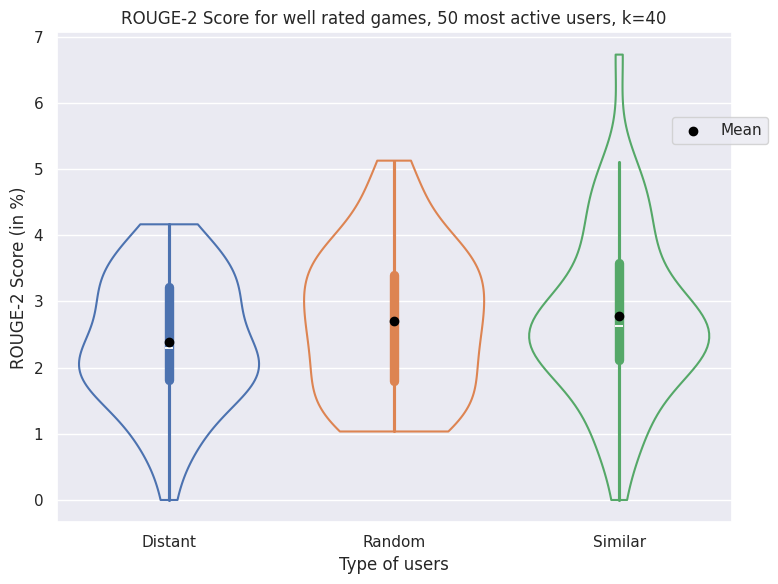

In [247]:
print(df_top50[['Similar', 'Random', 'Distant']].mean())

plt.figure(figsize=(8, 6))

df_melted = df_top50.melt(id_vars='User id', value_vars=['Distant', 'Random', 'Similar'], 
                    var_name='variable', value_name='value')
df_melted['value'] = df_melted['value'] * 100

group_means = df_melted.groupby('variable')['value'].mean()

# Overlay means as black diamonds
for i, (group, mean) in enumerate(group_means.items()):
    print(group)
    plt.scatter(i, mean, color='black', marker='o', zorder=10, label="Mean" if i == 0 else None)

sns.violinplot(x='variable', y='value', data=df_melted, hue='variable', inner='box', cut=0, fill=False)

plt.title("ROUGE-2 Score for well rated games, 50 most active users, k=40")
plt.ylabel("ROUGE-2 Score (in %)")
plt.xlabel("Type of users")
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.8))
plt.tight_layout()

# Plot violin plot
plt.savefig("Rouge_most_active_no_threshold.svg")

In [98]:
comments_all[comments_all["Game id"]==306]

,index,Game id,User id,Lemma,pos_neg
1428,1428,306,1,bingo tetris africain plaire majorite gens ne ...,positive
1429,1429,306,3,vrai jeu civilisation souffler ramener essen a...,negative
1430,1430,306,21,jeu regret mare nostrum phenomene ludique jeu ...,positive
1431,1431,306,54,wow claquer jeu dela min pas tasse the long ra...,positive
1432,1432,306,91,bloc sablier plateau remplir forme pierre prec...,negative
...,...,...,...,...,...
1494,1494,306,4429,vlaada jeu gestion abord theme tres fort civil...,positive
1495,1495,306,4708,mot manquer partie actif feroce envier suite r...,positive
1496,1496,306,4724,beau equilibrer tres instable evidement beaute...,positive
1497,1497,306,5020,perle ludique jeu editeur voir jeton ressource...,positive


In [299]:
a = []

np.random.seed(1)
for id in top_users[:50]:
    a.append(bev.knn_ROUGE(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = None))

In [300]:
# Create DataFrame
df = pd.DataFrame(a, columns=['Similar', 'Random', 'Distant'])
df.insert(0, 'User id', top_users[:50])

Similar    0.009394
Random     0.011585
Distant    0.008060
dtype: float64
Distant
Random
Similar


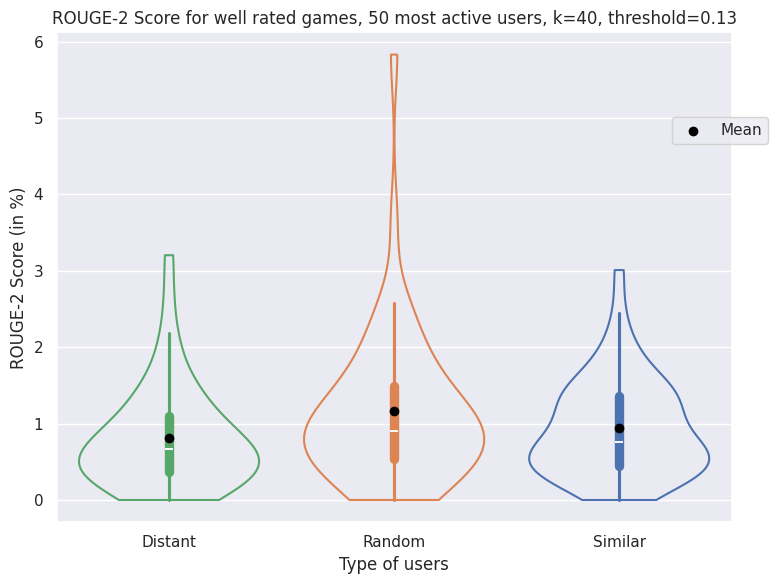

In [301]:
print(df[['Similar', 'Random', 'Distant']].mean())

plt.figure(figsize=(8, 6))

df_melted = df.melt(id_vars='User id', value_vars=['Similar', 'Random', 'Distant'], 
                    var_name='variable', value_name='value')
df_melted['value'] = df_melted['value'] * 100

group_means = df_melted.groupby('variable')['value'].mean()

# Overlay means as black diamonds
for i, (group, mean) in enumerate(group_means.items()):
    print(group)
    plt.scatter(i, mean, color='black', marker='o', zorder=10, label="Mean" if i == 0 else None)

sns.violinplot(x='variable', y='value', data=df_melted, hue='variable', inner='box', cut=0, fill=False, order=['Distant', 'Random', 'Similar'])

plt.title("ROUGE-2 Score for well rated games, 50 most active users, k=40, threshold=0.13")
plt.ylabel("ROUGE-2 Score (in %)")
plt.xlabel("Type of users")
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.8))
plt.tight_layout()
plt.savefig("Rouge_most_active_threshold.svg")
plt.show()

In [270]:
rand_200 = []
users_kept = []

np.random.seed(1)
random_users = np.random.choice(users_keeps, size=200, replace=False)

for id in random_users:
    res = bev.knn_ROUGE(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = -1, k = 40, topx = 150)
    if res is not None:
        rand_200.append(res) 
        users_kept.append(id)

In [271]:
# Create DataFrame
df_200 = pd.DataFrame(rand_200, columns=['Similar', 'Random', 'Distant'])
df_200.insert(0, 'User id', users_kept)
df_200

,User id,Similar,Random,Distant
0,3001,0.000000,0.000000,0.000000
1,1928,0.000000,0.083333,0.000000
2,577,0.012731,0.026709,0.017361
3,789,0.040816,0.035409,0.003663
4,8018,0.000000,0.000000,0.000000
...,...,...,...,...
128,3077,0.024810,0.022249,0.036357
129,3438,0.000000,0.000000,0.000000
130,2244,0.057058,0.027735,0.018211
131,636,0.038462,0.038462,0.038462


In [272]:
df_200[['Similar', 'Random', 'Distant']].mean()

Similar    0.023112
Random     0.024456
Distant    0.025668
dtype: float64

Distant
Random
Similar


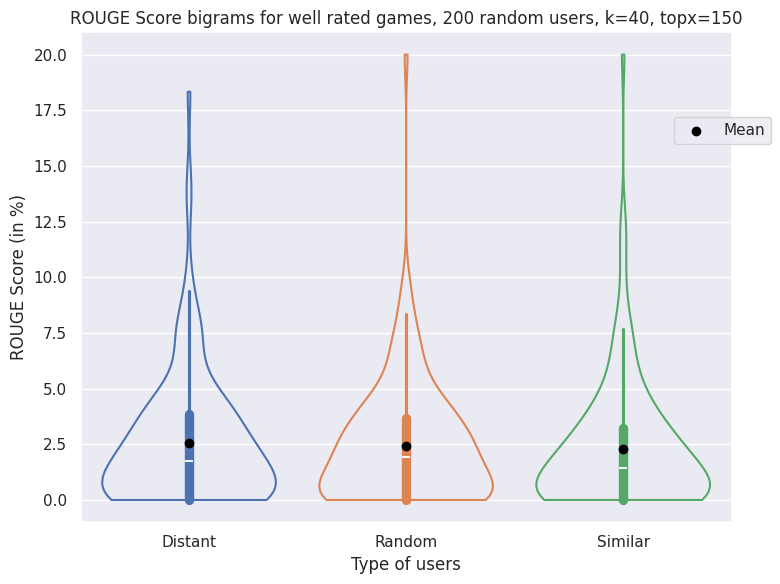

In [273]:
plt.figure(figsize=(8, 6))

df_melted = df_200.melt(id_vars='User id', value_vars=['Distant', 'Random', 'Similar'], 
                    var_name='variable', value_name='value')
df_melted['value'] = df_melted['value'] * 100

group_means = df_melted.groupby('variable')['value'].mean()

# Overlay means as black diamonds
for i, (group, mean) in enumerate(group_means.items()):
    print(group)
    plt.scatter(i, mean, color='black', marker='o', zorder=10, label="Mean" if i == 0 else None)


sns.violinplot(x='variable', y='value', data=df_melted, hue='variable', inner='box', cut=0, fill=False, order=['Distant', 'Random', 'Similar'])

plt.title("ROUGE Score bigrams for well rated games, 200 random users, k=40, topx=150")
plt.ylabel("ROUGE Score (in %)")
plt.xlabel("Type of users")
plt.legend(loc='center left', bbox_to_anchor=(0.9, 0.8))
plt.tight_layout()

# Plot violin plot
plt.savefig("Rouge_random_no_threshold_top150.svg")

With threshold 0.13

In [217]:
fuck

,index,Comment line,Game id,User id,Comment,Rating
0,0,0,6179,0,voyage aile papillon jeu jeu joli sensible sty...,8.0
1,1,1,6179,1,festival continuer apres mega hit apres oiseau...,7.0
2,2,2,6179,2,vivre vin jeu parvenir simuler epopee applique...,7.0
3,3,3,6179,3,manquer souffle plutot beau grand plateau peti...,7.0
4,4,4,6179,4,beau doux rapide jeu tension aller cours|cour ...,8.0
...,...,...,...,...,...,...
94686,94686,142459,6025,128,boum re petit jeu bien fun falloir tirer adver...,8.0
94687,94687,142460,6025,7597,star wars revisiter jeu vaisseau sympa joueur ...,6.0
94688,94688,142461,6025,4560,jeu rapide drole pretention passer moment regl...,8.0
94689,94689,142462,6025,3346,mort ne jouer moyen pas fouiller bien strategi...,4.0


In [233]:
a = []
users_kept = []

np.random.seed(1)
# random_users = np.random.choice(users_keeps, size=200, replace=False)

for id in top_users[:50]:
    res = bev.knn_ROUGE(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, fuck, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = None)
    if res[0] is not None:
        a.append(res) 
        users_kept.append(id)

In [234]:
rouge_1 = [t[0] for t in a]  # list of tuples (1,2,3), (7,8,9), ...
rouge_2 = [t[1] for t in a]

# Create DataFrame
df = pd.DataFrame({
    'rouge_1_similar': [x[0] for x in rouge_1],
    'rouge_1_random': [x[1] for x in rouge_1],
    'rouge_1_distant': [x[2] for x in rouge_1],
    'rouge_2_similar': [x[0] for x in rouge_2],
    'rouge_2_random': [x[1] for x in rouge_2],
    'rouge_2_distant': [x[2] for x in rouge_2],
})

In [235]:
df.rename(columns={
    'rouge_1_similar': 'Similar',
    'rouge_1_random': 'Random',
    'rouge_1_distant': 'Distant'
}, inplace=True)

In [229]:
df

,User id,Similar,Random,Distant,rouge_2_similar,rouge_2_random,rouge_2_distant
0,1976,0.000000,0.000000,0.000000,40.000000,25.000000,15.000000
1,1928,0.011301,0.000000,0.011301,39.282853,20.933494,26.602564
2,577,0.000000,0.006912,0.008798,26.308437,26.213669,26.829122
3,789,0.007478,0.006320,0.005705,25.296945,29.441616,24.289889
4,4556,0.000000,0.034483,0.068966,25.925926,33.333333,44.444444
...,...,...,...,...,...,...,...
123,3077,0.000000,0.000000,0.013889,26.028312,23.671207,29.153312
124,2244,0.006897,0.003448,0.013793,33.568146,32.376736,19.468791
125,636,0.021315,0.010204,0.011111,30.773810,27.202381,21.964286
126,2783,0.000000,0.000000,0.000000,27.450980,23.529412,21.568627


In [237]:
df.insert(0, 'User id', users_kept)
df.set_index("User id")

,Similar,Random,Distant,rouge_2_similar,rouge_2_random,rouge_2_distant
User id,,,,,,
208,0.012805,0.013445,0.013489,36.918344,33.245698,34.145229
83,0.002863,0.006906,0.007760,24.211620,24.073231,23.297198
1,0.007853,0.008935,0.006706,27.259847,25.857845,24.677421
91,0.013071,0.014063,0.008673,25.343858,25.693988,24.480742
201,0.005650,0.004411,0.005087,19.148210,19.096356,15.245554
1724,0.013446,0.011199,0.010591,24.353046,28.594764,24.724754
1936,0.022267,0.049643,0.026108,38.016172,35.371322,30.796725
2747,0.000592,0.002442,0.009352,28.695090,24.838070,24.143055
1998,0.013235,0.013844,0.000000,35.409283,33.763413,30.067806


In [232]:
# # Create DataFrame
# df = pd.DataFrame(a, columns=['Similar', 'Random', 'Distant'])
# df.insert(0, 'User id', users_kept)
# df.set_index("User id")

In [373]:
df[['Similar', 'Random', 'Distant']].mean()

Similar    0.009242
Random     0.009007
Distant    0.010286
dtype: float64

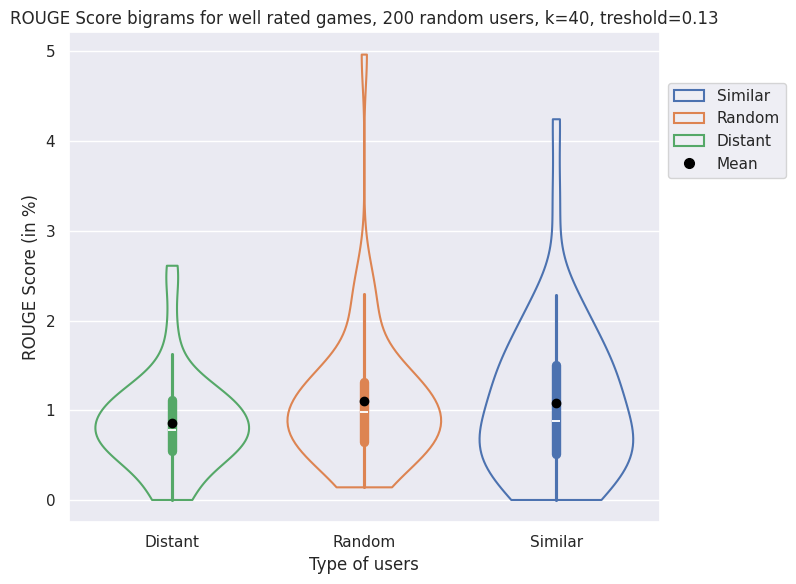

In [238]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

plt.figure(figsize=(8, 6))

df_melted = df.melt(id_vars='User id', value_vars=['Similar', 'Random', 'Distant'], 
                    var_name='variable', value_name='value')
df_melted['value'] = df_melted['value'] * 100
df_melted['type'] = df_melted['variable'] 
group_means = df_melted.groupby('variable')['value'].mean()

palette = sns.color_palette()  # or your custom palette
hue_categories = df_melted['variable'].unique()
patches = [Patch(edgecolor=palette[i], facecolor='none', label=cat, linewidth=1.5) for i, cat in enumerate(hue_categories)]

sns.violinplot(x='variable', y='value', data=df_melted, hue='type', inner='box', cut=0, fill=False, order=["Distant", "Random", "Similar"])

lab = ['Mean Similar', 'Mean Random', 'Mean Less Similar']
for i, (group, mean) in enumerate(group_means.items()):
    plt.scatter(i, mean, color='black', zorder=10, label="Mean" if i==0 else None)

mean_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=7, label='Mean')

# Combine patch handles and the mean handle
all_handles = patches + [mean_handle]

plt.title("ROUGE Score bigrams for well rated games, 200 random users, k=40, treshold=0.13")
plt.ylabel("ROUGE Score (in %)")
plt.xlabel("Type of users")
plt.legend(handles=all_handles, loc='center left', bbox_to_anchor=(1, 0.8))


# plt.savefig("Rouge_random_threshold.svg")
plt.tight_layout()
plt.show()

Annexe plot for 50 users

In [349]:
my_list = [83, 91, 92, 94, 291, 455, 574, 885, 934, 1816, 1899, 1900, 1906, 1998, 2994]

In [466]:
df_longR1 = scores_all_top[scores_all_top['Pred by'] == 'R1'].melt(id_vars=['User id'], 
                  value_vars=['Similar', 'Random', 'Distant'],
                  var_name='type', 
                  value_name='values')

# Step 2: Explode the lists into rows
df_longR1 = df_longR1.explode('values')

In [467]:
df_longR2 = scores_all_top[scores_all_top['Pred by'] == 'R2'].melt(id_vars=['User id'], 
                  value_vars=['Similar', 'Random', 'Distant'],
                  var_name='type', 
                  value_name='values')

# Step 2: Explode the lists into rows
df_longR2 = df_longR2.explode('values')

In [474]:
avis_clean[avis_clean['Username'] =='Dexter269']

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body
646,8908,420,TAJUTO,Dexter269,2019-09-30 12:01:38,8.6,Reconnaissance tactile à la sauce Knizia,Avis complet ici : https://ludidice.wordpress....
694,1620,420,Ceylan,Dexter269,2019-10-20 16:14:10,9.8,A déguster avec une tasse de thé,Avis complet ici : https://ludidice.wordpress....
1145,4960,420,La Quête du Bonheur,Dexter269,2019-08-14 09:06:16,9.4,Jouez la vie de vos rêves !,Avis complet ici : https://ludidice.wordpress....
1714,10108,420,"Welcome-extension 1 -paques, guerre froide et ...",Dexter269,2019-05-15 09:24:14,9.5,Change la manière de jouer sans complexifier l...,Avis complet ici : https://ludidice.wordpress....
1742,6698,420,Mū,Dexter269,2019-07-17 11:43:05,8.6,Système de draft intéressant,Avis complet ici : https://ludidice.wordpress....
...,...,...,...,...,...,...,...,...
79124,3807,420,Hansa Teutonica,Dexter269,2016-07-28 10:23:10,9.9,Excellent kubenbois,Hansa Teutonica est un jeu sans hasard. Le seu...
86886,7298,420,Piratatak,Dexter269,2017-07-11 09:59:48,7.9,Stop ou encore avec des pirates,Idéal pour s'amuser tout en faisant quelques c...
133236,6421,420,Mississippi Queen,Dexter269,2019-08-26 20:30:39,9.7,Très bon jeu de course de bateaux,Avis complet ici : https://ludidice.wordpress....
141118,3779,420,Haleakala,Dexter269,2017-01-17 16:48:51,5.8,Un jeu abstrait assez sympa,"N'étant pas fan des jeux abstraits, je suis as..."


In [458]:
df_longR1 = df_longR1[df_longR1['User id'].isin(rand_list)].dropna()

In [459]:
df_longR2 = df_longR2[df_longR2['User id'].isin(rand_list)].dropna()

In [469]:
df_longR1['type'] = df_longR1['type'].replace({
    'Similar': 'Similar users',
    'Random': 'Random users',
    'Distant': 'Distant users'
})

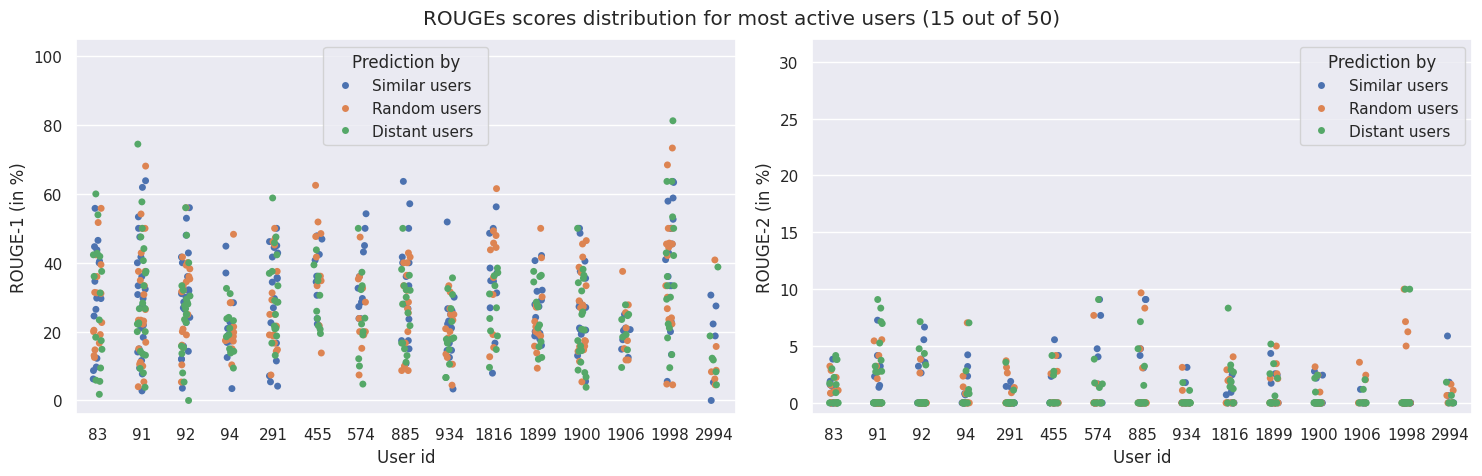

In [471]:
np.random.seed(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# top_users_sample = np.random.choice(scores_all_top["User id"].unique(), size=15)
# df_top = scores_all_top[scores_all_top["User id"].isin(my_list)]
# df_top = df_top[df_top["Pred by"] == "R1"] 
# print(df_top)

sns.stripplot(data=df_longR1, x="User id", y="values", hue="type", jitter=True, dodge=False, ax=ax1)
sns.stripplot(data=df_longR2, x="User id", y="values", hue="type", jitter=True, dodge=False, ax=ax2)

ax1.set_ylabel("ROUGE-1 (in %)")
ax2.set_ylabel("ROUGE-2 (in %)")
ax1.legend(title="Prediction by")
ax2.legend(title="Prediction by")

ax1.set_ylim(-4, 105)
ax2.set_ylim(-1, 32)

fig.suptitle("ROUGEs scores distribution for most active users (15 out of 50)", y=0.95)
plt.tight_layout()
plt.savefig("jitter_top_R12_big.svg")

In [195]:
fuck['User id'].unique()

array([   0,    1,    2, ..., 9965, 5849, 3069])

In [ ]:
# scores_all = pd.DataFrame(columns=['User id', 'Similar', 'Random', 'Distant'])

# nb = 0
# np.random.seed(1)
# random_users = np.random.choice(fuck['User id'].unique(), size=200, replace=False)

# for id in top_users[:50]:
#     scores_user = bev.knn_ROUGE_annexe(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, fuck, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
#     if scores_user is None:
#         continue
#     nb += 1
#     user_df = pd.DataFrame(list(zip(*scores_user)), columns=['Similar', 'Random', 'Distant'])
#     user_df['User id'] = id
#     scores_all = pd.concat([scores_all, user_df])
# print(nb)

/tmp/ipykernel_8244/2345977125.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_all = pd.concat([scores_all, user_df])
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


15


In [446]:
# random
scores_all_rand = scores_all

In [392]:
# top 50
scores_all_top = scores_all

In [439]:
type(np.array([(None),(None)])[0])

NoneType

In [464]:
scores_all = pd.DataFrame(columns=['User id', 'Pred by', 'Similar', 'Random', 'Distant'])

nb = 0
np.random.seed(1)
# random_users = np.random.choice(fuck['User id'].unique(), size=200, replace=False)

for id in my_list:
    scores_user = bev.knn_ROUGE_annexe(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, fuck, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
    R2, R1 = scores_user
    R2, R1 = R2.tolist(), R1.tolist()
    nb += 1
    user_df = pd.DataFrame([
    [id, 'R1'] + R1,
    [id, 'R2'] + R2,
    ], columns=['User id', 'Pred by', 'Similar', 'Random', 'Distant'])
    scores_all = pd.concat([scores_all, user_df])
print(nb)

KeyboardInterrupt: 

In [445]:
scores_all

,User id,Pred by,Similar,Random,Distant
0,3382,R1,[],[],[]
1,3382,R2,[],[],[]
0,2894,R1,[27.27272727272727],[36.36363636363637],[27.27272727272727]
1,2894,R2,[0.0],[0.0],[0.0]
0,2274,R1,"[37.9746835443038, 14.634146341463413, 13.5593...","[40.50632911392405, 19.51219512195122, 8.47457...","[35.44303797468354, 3.6585365853658534, 16.101..."
...,...,...,...,...,...
1,3839,R2,"[0.0, 0.0]","[0.0, 0.0]","[0.0, 7.142857142857142]"
0,6386,R1,[],[],[]
1,6386,R2,[],[],[]
0,10,R1,[23.809523809523807],[42.857142857142854],[19.047619047619047]


In [385]:
scores_all[scores_all['Pred by']=='R1']

,User id,Pred by,Similar,Random,Distant
0,83,R1,"[43.75, 40.44943820224719, 6.25, 26.4705882352...","[31.25, 51.68539325842697, 12.5, 14.7058823529...","[37.5, 53.93258426966292, 1.7857142857142856, ..."
0,91,R1,"[47.5, 53.333333333333336, 40.0, 18.3333333333...","[37.5, 23.333333333333332, 33.33333333333333, ...","[47.5, 26.666666666666668, 26.666666666666668,..."
0,92,R1,"[56.00000000000001, 36.0, 40.0, 41.66666666666...","[36.0, 40.0, 56.00000000000001, 41.66666666666...","[40.0, 32.0, 56.00000000000001, 25.0, 0.0, 8.0..."
0,94,R1,"[17.24137931034483, 12.5, 3.4482758620689653, ...","[10.344827586206897, 15.0, 17.24137931034483, ...","[24.137931034482758, 15.0, 13.793103448275861,..."
0,291,R1,"[46.15384615384615, 42.857142857142854, 50.0, ...","[29.230769230769234, 19.047619047619047, 50.0,...","[36.92307692307693, 28.57142857142857, 58.8235..."
0,455,R1,"[22.22222222222222, 36.11111111111111, 30.5555...","[33.33333333333333, 41.66666666666667, 36.1111...","[19.444444444444446, 36.11111111111111, 30.555..."
0,574,R1,"[32.608695652173914, 54.23728813559322, 23.809...","[32.608695652173914, 47.45762711864407, 28.571...","[23.91304347826087, 32.20338983050847, 19.0476..."
0,885,R1,"[40.0, 26.666666666666668, 63.63636363636363, ...","[40.0, 26.666666666666668, 36.36363636363637, ...","[33.33333333333333, 16.666666666666664, 36.363..."
0,934,R1,"[23.076923076923077, 3.3333333333333335, 14.58...","[13.461538461538462, 26.666666666666668, 12.5,...","[30.76923076923077, 6.666666666666667, 22.9166..."
0,1816,R1,"[56.25, 7.936507936507936, 37.03703703703704, ...","[43.75, 12.698412698412698, 44.44444444444444,...","[18.75, 23.809523809523807, 14.814814814814813..."


In [451]:
rand_list = [5014, 2308, 2295, 7263, 3138, 4333, 2442,  886, 1972, 6514, 1774, 2198, 2706, 4595, 5012]

/tmp/ipykernel_8244/3389781681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_50['User id'] = chosen_50['User id'].astype(str)
/tmp/ipykernel_8244/3389781681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_50[['Similar', 'Random', 'Distant']] = chosen_50[['Similar', 'Random', 'Distant']].astype(int)


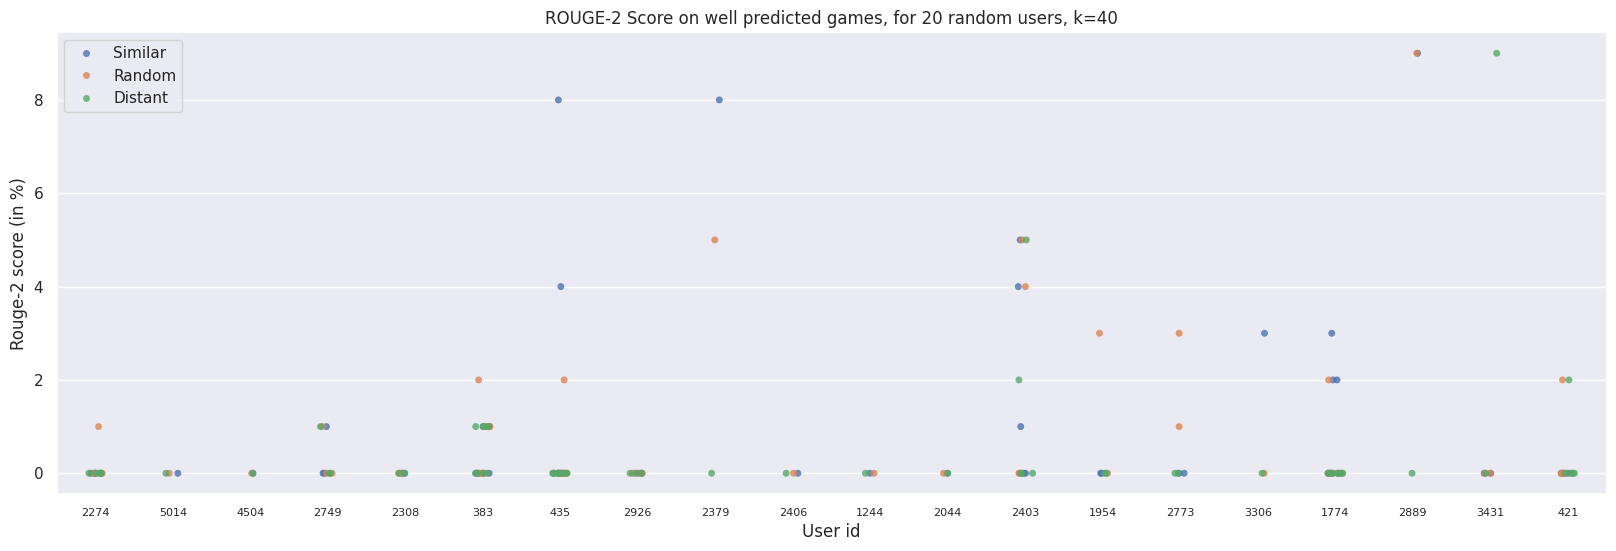

In [216]:
plt.figure(figsize=(20, 6))

np.random.seed(1)
random_50 = np.random.choice(scores_all['User id'].unique(), 20)
chosen_50 = scores_all[scores_all['User id'].isin(random_50)]

chosen_50['User id'] = chosen_50['User id'].astype(str)
chosen_50[['Similar', 'Random', 'Distant']] = chosen_50[['Similar', 'Random', 'Distant']].astype(int)

df_melted = chosen_50.melt(
    id_vars='User id',
    value_vars=['Similar', 'Random', 'Distant'],
    var_name='Type',
    value_name='Score'
)

# mean_scores = chosen_50.groupby('User id')[['Similar', 'Random', 'Distant']].mean().reset_index()

# sns.lineplot(data=mean_scores, x="User id", y='Similar', color='black', label='Mean', marker='o', sizes=15, alpha=0.6)
sns.stripplot(data=df_melted, x="User id", y='Score',hue='Type', alpha=0.8, size=5)

plt.xticks(fontsize=8)
plt.xlabel('User id')
plt.ylabel('Rouge-2 score (in %)')
plt.title('ROUGE-2 Score on well predicted games, for 20 random users, k=40')
plt.legend()

# plt.savefig('ROUGE2_random_annexe(20)bis.svg')
plt.show()

In [319]:
avis_clean[(avis_clean['User id'] == 201) & (avis_clean['Game id'] == 10409)]

,Game id,User id,Game name UI,Username,Datetime,Rating,Comment title,Comment body
39079,10409,201,Zombie Dice Deluxe,Gigi,2011-04-18 12:29:00,4.0,Dés cérébrés !,Zombie Dice est un petit jeu de stop ou encore...


In [103]:
import ollama
from nltk import bigrams

ref1 = avis_clean[(avis_clean['User id'] == 0) & (avis_clean['Game id'] == 6179)]["Comment body"].values[0] # rated 8.0
hyp1 = comments_all[(comments_all['User id'] == 0)& (comments_all['Game id'] == 6179)]['Lemma'].values[0]

ref2 = avis_clean[(avis_clean["User id"] == 2258)& (avis_clean["Game id"] == 4118)]["Comment body"].values[0] # rated 2.0
hyp2 = comments_all[(comments_all["User id"] == 2258) & (comments_all["Game id"] == 4118)]['Lemma'].values[0]

def generate_summary_from_bigrams(bigram_list, model='llama3.2:1b'):
    
    messages = [
        {
            "role": "system",
            "content": (
                "You will be given a list of bigrams that correspond to the words of a player's comment for a game. "
                "You have to write a summary about the game as if you were that player, in 15 sentences max. "
                "The comment should keep the relevent information from the bigrams, and is in french."
            )
        },
        {"role": "user", "content": str(list(bigrams(hyp1.split())))},
        {"role": "assistant", "content": ref1},
        {"role": "user", "content": str(list(bigrams(hyp2.split())))},
        {"role": "assistant", "content": ref2},
        {"role": "user", "content": str(bigram_list)}
    ]

    # Call the model
    response = ollama.chat(model=model, messages=messages)

    return response['message']['content']


In [311]:
import ollama
from nltk import bigrams

ref1 = avis_clean[(avis_clean['User id'] == 0) & (avis_clean['Game id'] == 6179)]["Comment body"].values[0] # rated 8.0
hyp1 = comments_all[(comments_all['User id'] == 0)& (comments_all['Game id'] == 6179)]['Lemma'].values[0]

ref2 = avis_clean[(avis_clean["User id"] == 2258)& (avis_clean["Game id"] == 4118)]["Comment body"].values[0] # rated 2.0
hyp2 = comments_all[(comments_all["User id"] == 2258) & (comments_all["Game id"] == 4118)]['Lemma'].values[0]

def generate_summary_from_bigrams(bigram_list, model='llama3.2:1b'):
    
    messages = [
        {
            "role": "system",
            "content": (
                "You will be given a list of words that correspond to the words of a player's comment for a game. "
                "You have to write a summary about the game as if you were that player, in 15 sentences max. "
                "The comment should keep the relevent information from the bigrams, and is in french."
            )
        },
        {"role": "user", "content": str(list(hyp1.split()))},
        {"role": "assistant", "content": ref1},
        {"role": "user", "content": str(list(hyp2.split()))},
        {"role": "assistant", "content": ref2},
        {"role": "user", "content": str(bigram_list)}
    ]

    # Call the model
    response = ollama.chat(model=model, messages=messages)

    return response['message']['content']


In [187]:
fuck

,index,Comment line,Game id,User id,Comment
0,0,0,6179,0,voyage aile papillon jeu jeu joli sensible sty...
1,1,1,6179,1,festival continuer apres mega hit apres oiseau...
2,2,2,6179,2,vivre vin jeu parvenir simuler epopee applique...
3,3,3,6179,3,manquer souffle plutot beau grand plateau peti...
4,4,4,6179,4,beau doux rapide jeu tension aller cours|cour ...
...,...,...,...,...,...
94686,94686,142459,6025,128,boum re petit jeu bien fun falloir tirer adver...
94687,94687,142460,6025,7597,star wars revisiter jeu vaisseau sympa joueur ...
94688,94688,142461,6025,4560,jeu rapide drole pretention passer moment regl...
94689,94689,142462,6025,3346,mort ne jouer moyen pas fouiller bien strategi...


In [186]:
fuck = fuck.reset_index(names="index")

In [199]:
np.sum(scores_user)/len(scores_user)

26.875039967076745

In [302]:
np.random.seed(23)
scores_user = bev.knn_ROUGE(201, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, fuck, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
scores_user

438
inter simi
taille 60
intersection!!!
['pas' 'jeu' 'rythme' 'ne' 'voir' 'cela' 'fin' 'niveau' 'si' 'materiel'
 'craindre' 'bien' 'rien' 'jouer' 'petit' 'pousser' 'plateau' 'nombreux']
user rand
taille 72
intersection!!!
['jeu' 'ystari' 'si' 'partie' 'ne' 'rien' 'jouer' 'choix' 'bien' 'un'
 'different' 'apres' 'etre' 'joueur' 'equilibrer' 'tres' 'interesser'
 'choisir' 'petit' 'bout' 'regle' 'penser' 'plantation' 'plateau']
user dist
taille 50
intersection!!!
['jeu' 'pas' 'tres' 'ne' 'grand' 'si' 'nombreux' 'choix' 'gestion'
 'meilleur' 'ystari' 'jouer' 'importance' 'regle' 'bien' 'partie' 'point'
 'temps' 'interesser' 'editeur']
660
inter simi
taille 46
intersection!!!
['jeu' 'ne' 'partie' 'bien' 'mecanisme' 'simple' 'permettre' 'pas' 'etre'
 'point' 'voir' 'representer' 'influence' 'fin' 'regle' 'court']
user rand
taille 47
intersection!!!
['jeu' 'guerre' 'ne' 'pas' 'tribu' 'joueur' 'carte' 'point' 'theme'
 'abstrait' 'oublier' 'bien' 'provoquer']
user dist
taille 55
intersection!!

(array([0.65684637, 0.51087106, 1.0966704 ]),
 array([17.91818473, 16.27639196, 16.86271692]))

In [287]:
np.random.seed(23)
scores_user = bev.knn_ROUGE_annexe(201, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, fuck, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
scores_user

438
201 438
doc
['amyitis jeu' 'avoir concevoir' 'avance pas' 'beau materiel'
 'bemol trouver' 'bien integrer' 'cela pas' 'cela profiter' 'cela voir'
 'falloir rien' 'jouer niveau' 'materiel plaisir' 'ne avance'
 'necessaire jeu' 'niveau falloir' 'oublier aller' 'pas confirmer'
 'pas oublier' 'perdre voir' 'petit bemol' 'pousser cela' 'profiter si'
 'rapporter cela' 'aller petit' 'voir tourner' 'strategie nombreux'
 'mecanique fin' 'beau voir' 'concevoir mecanique' 'esthetique plateau'
 'falloir prendre' 'interaction jeu' 'jeu fin' 'jeu savoir' 'jeu suisse'
 'luxer ne' 'pas accro' 'savoir lire' 'pas interaction' 'pas niveau'
 'pas possible' 'pied pas' 'plateau ne' 'possible avoir' 'prendre rythme'
 'rythme falloir' 'rythme jeu' 'rien perdre']
['jardin francais', 'francais jeu', 'jeu majorite', 'majorite haut', 'haut gamme', 'gamme lecture', 'lecture regle', 'regle jeu', 'jeu digne', 'digne meilleur', 'meilleur tour', 'tour jeu', 'jeu suffire', 'suffire convaincre', 'convaincre choix', 

array([[0.        , 0.65359477, 0.        , 0.        , 2.02020202,
        2.4691358 , 1.08695652, 1.12359551, 0.        , 0.        ,
        3.44827586, 0.        , 0.47619048, 1.25      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.26582278],
       [0.        , 0.65359477, 0.        , 0.70921986, 1.01010101,
        0.        , 0.        , 0.        , 1.31578947, 0.        ,
        2.5862069 , 0.        , 0.        , 1.25      , 0.        ,
        1.11111111, 0.        , 0.        , 0.        , 0.82644628,
        1.26582278],
       [0.        , 0.65359477, 1.75438596, 0.        , 2.02020202,
        0.        , 1.08695652, 1.12359551, 1.31578947, 0.        ,
        0.86206897, 0.        , 0.        , 1.25      , 0.        ,
        5.55555556, 1.4354067 , 0.        , 0.96153846, 2.47933884,
        2.53164557]])

In [290]:
scores_user.mean(axis=1)

array([0.65684637, 0.51087106, 1.0966704 ])

In [294]:
sim_g = generate_summary_from_bigrams(user_sim)
sim_g

"Après cette partie, je pense que les jeux sont un peu trop répétitifs. Le jeu de découverte est vraiment la part la plus agréable du jeu, mais il y a beaucoup de fois où tout se fait par erreur et alors on se rend compte qu'il n'y a pas de règles pour savoir si c'est vrai ou faux, ce qui pénètre dans l'esprit de déception. Je pense que cela devrait être rectifié afin d'éviter ces erreurs et de rendre le jeu plus agréable à jouer (je ne suis pas sûr si c'est réellement possible mais il faut essayer)."

In [309]:
unig_llm

['pas', 'jeu', 'de', 'theme', 'grand', 'rester']

In [316]:
rand_g = generate_summary_from_bigrams(unig_llm)
rand_g

"J'ai été dépassé par un jeu de défaut qui est une boîte de chance. Je suis tombé dans l'abîme d'une zombie des décès (je ne comprends pas pourquoi je dois encore jouer...). Et pourtant, la règle du jeu s'appelait 'dice', et c'est avec ce tour que j'ai eu le défi de réussir à sortir de cette situation désastreuse. Malheureusement, il y a d'autres défis que les zombies des décès peuvent me porter ! Mais comme un vrai géant du monde virtuel, je préfère continuer à jouer pour essayer de gagner...mais c'est pas facile dans ce jeu-là."

In [296]:
dist_g = generate_summary_from_bigrams(user_dist)
dist_g

"Laissez les zombies aller, il est trop facile. Je trouve la situation très rassurante pour un jeu de rôle comme ça. C'est toujours plus agréable de faire des révélations sur le plan et les défauts du personnage à partir d'un lancement rapide, mais la qualité et la chance ont beaucoup changé tout le jeu en plus. Les mains sont désormais devenues les yeux, et il y a si peu de main qui se cache dans les ruses de ce jeu... Mais puisque c'est facile comme ça, on peut aussi jouer à stop comme un jeu d'arcade !"

In [117]:
avis_clean[(avis_clean["Game id"]== 10409) & (avis_clean["User id"]== 201)]['Comment body'].values[0]

"Zombie Dice est un petit jeu de stop ou encore sans prétention mais aussi sans grande saveur. On ne réfléchit pas beaucoup et la chance est omniprésente. Le thème bien qu'anecdotique colle finalement bien aux mécanismes... Qu'importe ! Le but ici est plutôt de se dérouiller la cervelle (à défaut d'en manger !) après un gros jeu ou encore pendant un apéritif. On s'amuse de la malchance des adversaires et on se moque des prises de risque trop audacieuses qui achoppent. Même si les parties sont très courtes, on n'en fait pas plusieurs d'affilées tant le jeu devient vite répétitif et lassant. Zombie Dice ne restera pas dans les annales du genre. Dans la même catégorie il y a des jeux bien plus réussis et plus attractifs tant par leur matériel que par le fun qu'ils engendrent autour d'une table. Il ne suffit pas de coller des cerveaux sur des dés à 8 faces et une image de zombie racoleuse sur une boite pour transformer un banal jeu de dés en distraction originale."

In [123]:
rev_filter_center
rev_filter_center[(rev_filter_center["Game id"]== 10409) & (rev_filter_center["User id"]== 201)]['Comment body'].values[0]

"Zombie Dice est un petit jeu de stop ou encore sans prétention mais aussi sans grande saveur. On ne réfléchit pas beaucoup et la chance est omniprésente. Le thème bien qu'anecdotique colle finalement bien aux mécanismes... Qu'importe ! Le but ici est plutôt de se dérouiller la cervelle (à défaut d'en manger !) après un gros jeu ou encore pendant un apéritif. On s'amuse de la malchance des adversaires et on se moque des prises de risque trop audacieuses qui achoppent. Même si les parties sont très courtes, on n'en fait pas plusieurs d'affilées tant le jeu devient vite répétitif et lassant. Zombie Dice ne restera pas dans les annales du genre. Dans la même catégorie il y a des jeux bien plus réussis et plus attractifs tant par leur matériel que par le fun qu'ils engendrent autour d'une table. Il ne suffit pas de coller des cerveaux sur des dés à 8 faces et une image de zombie racoleuse sur une boite pour transformer un banal jeu de dés en distraction originale."

In [292]:
import textwrap
print("For topx=150")
print("User's comment:")
print("\n".join(textwrap.wrap(fuck[(fuck["Game id"]== 10409) & (fuck["User id"]== 201)]['Comment'].values[0], width=150)))
print("Generated text: similar user")
print("\n".join(textwrap.wrap(sim_g, width=150)))
print("Generated text: random user")
print("\n".join(textwrap.wrap(rand_g, width=100)))
print("Generated text: distant user")
print("\n".join(textwrap.wrap(dist_g, width=100)))

For topx=150
User's comment:
de zombie dice petit jeu stop pretention grand saveur ne reflechir pas chance omnipresent theme bien anecdotique coller bien mecanisme importer but
plutot cervelle defaut manger apres gros jeu aperitif amuser malchance adversaire moque prendre risquer audacieux si partie tres court ne pas affiler
jeu devenir vite repetitif lasser zombie dice ne rester pas genre categorie jeu bien reussir attractif materiel fun engendrer autour table ne suffire
pas coller cerveau de face image zombie boite transformer banal jeu de original
Generated text: similar user
Je l'ai laissé partir dans ce jeu...c'était une bonne décision. Les enfants n'étaient pas trop mal disposés et étaient prêts à quitter le jeu pour
aller manger. Mais le jeu était mineur, il fallait mettre un peu d'humour et de créativité. Nous avons passé quelques minutes à imaginer tout ce qui
pourrait se passer après la partie, mais nous ne l'avons jamais vraiment fait...c'était trop ennuyeux, comme si les en

In [293]:
user_sim = [('apres', 'partie'), ('depart', 'petit'), ('etre', 'depart'), ('faim', 'apres'),
 ('jeu', 'laisser'), ('laisser', 'faim'), ('parer', 'etre'), ('partie', 'decevoir'),
 ('petit', 'jeu')]

user_rand = [('basique', 'jouer'), ('basique', 'pas'), ('chose', 'rester'), ('grand', 'chose'),
 ('jeu', 'de'), ('pas', 'grand'), ('pas', 'theme'), ('rester', 'ultra'),
 ('theme', 'pas'), ('ultra', 'basique')]

user_dist = [('accessible', 'rapide'), ('oublier', 'etre'), ('voir', 'boite'), ('tres', 'facile'),
 ('stop', 'tres'), ('sortir', 'qualite'), ('simple', 'genre'), ('rien', 'main'),
 ('rapide', 'sortir'), ('qualite', 'defaut'), ('perdre', 'avoir'), ('pas', 'dame'),
 ('oublier', 'si'), ('jeu', 'stop'), ('avoir', 'perdre'), ('jeu', 'accessible'),
 ('facile', 'acces'), ('etre', 'cher'), ('dice', 'jeu'), ('debuter', 'soiree'),
 ('dame', 'chance'), ('cher', 'voir'), ('chance', 'lance'), ('base', 'avoir'),
 ('bang', 'mort'), ('avoir', 'rien'), ('zombie', 'dice')]

In [314]:
unig_llm = ['jeu', 'boite', 'si', 'ne', 'pas', 'chance', 'defaut', 'dice', 'stop', 'tres',
 'cerveau', 'zombie', 'genre', 'de']


In [89]:
comments_all[(comments_all["Game id"]== 10409) & (comments_all["User id"]== 201)]['Lemma'].values[0]

'viking expedition de cela joli emballage incarner chef viking devoir rapporter richesse prestige effectuer different raid plateau central composer petit plateau assembler donner impression un bout carte tour joueur aller lancer de possession jeton viking debut un tour placer jeton carte suivant regle poser plateau essayer obtenir majorite plateau nord etre nombre point total prendre compter si exemple joueur choisir de place jeton viking ligner disponible total instant plateau central etre suite grand prendre compter si exemple joueur choisir de place jeton emplacement ligner disponible plateau etre suite longue nombre jeton viking remporter majorite plateau sud etre nombre jeton empiler prendre compter si exemple joueur choisir de jeton ligner disponible etre pile haut gagner majorite tour arreter joueur rentrer village ne souhaiter ne jouer si rester jeton viking gagner rune jeton restant permettre prochain tour rune modifier de passer phase majorite plateau commencer nord sud regar

In [366]:
scores_all = pd.DataFrame(columns=['User id', 'Similar', 'Random', 'Distant'])
nb = 0

np.random.seed(1)
random_users = np.random.choice(users_keeps, size=200, replace=False)

for id in random_users:
    scores_user = bev.knn_ROUGE_annexe(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
    if scores_user is None:
        continue
    nb += 1
    user_df = pd.DataFrame(list(zip(*scores_user)), columns=['Similar', 'Random', 'Distant'])
    user_df['User id'] = id
    scores_all = pd.concat([scores_all, user_df])
print(nb)

/tmp/ipykernel_91508/2410291128.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_all = pd.concat([scores_all, user_df])


1821 2278
doc
['toc toc' 'jeu parer' 'aller baisser' 'averer etre' 'carte figurine'
 'controle rien' 'decevoir prix' 'depasser borner' 'dire ok'
 'enchere gagner' 'etre ultra' 'figurine ne' 'final pas' 'gagner enchere'
 'gestion guerre' 'joueur attendre' 'tour proposer' 'joueur theme'
 'matos plutot' 'mettre si' 'of empire' 'ok aller' 'parent joueur'
 'plutot chouette' 'prix gros' 'prix prix' 'public ne' 'rien penser'
 'theme interesser' 'triste dire' 'voiler petit' 'raconter ne'
 'aller cela' 'tourner joueur' 'aller pas' 'bluff cela' 'bluff ne'
 'bug bluff' 'cela aller' 'cela voir' 'jeu bluff' 'joueur carte'
 'monde arriver' 'ne aller' 'pas aimer' 'percer jour' 'roue tourner'
 'carte dire' 'proposer carte' 'carte moment' 'devoir passer'
 'dire verite' 'donner carte' 'falloir tour' 'fois accepter' 'interet jeu'
 'jeu donner' 'jeu mettre' 'marcher falloir' 'moment convivialite'
 'ne importer' 'passer bien' 'voir final']
['reussir quoridor', 'quoridor beau', 'beau tactique', 'tactique pa

In [368]:
# user 1821 rouge 30% 
vois1821 = [
    'bien chose', 'rare jeu', 'bruire de', 'de boite', 'empeche pas', 'jeu bas',
    'jeu sympathique', 'jouer anglais', 'ludique ne', 'manche apres', 'mot venir',
    'ne empeche', 'occuper bien', 'pas rester', 'temps bien', 'bruire rien',
    'temps mort', 'travailler vocabulaire', 'venir esprit', 'adorer petit',
    'ideal initier', 'initier jeu', 'jeu mot', 'jeu rapide', 'minute vite',
    'petit jeu', 'rapide minute', 'scrabble adorer', 'boite plastique',
    'bien temps', 'bien rapide', 'bien classique', 'chose difficile', 'chose mot',
    'de ne', 'difficile trouver', 'etre repetitif', 'etre vrai', 'gagner limite',
    'hasard bien', 'jeu lettre', 'jouer gagner', 'lettre trouver', 'mauvais jeu',
    'meme mot', 'mot lettre', 'mot revenir', 'pas retomber', 'placement si',
    'possible hasard', 'repetitif possible', 'rester mauvais', 'rien etre',
    'scrabble jeu', 'trouver chose', 'vrai aimer', 'apres aimer', 'vite ideal'
]

hyp1821= [tuple(bigram.split()) for bigram in vois1821[:100]]
ref1821 = avis_clean[(avis_clean['User id'] == 1821) & (avis_clean['Game id'] == 4451)]['Comment body'].values[0]
ref1821

'Très très bon jeu qui tient plus de Diaballik que de la simulation sportive, avec un système de cartes qui rappelle les combats de Dungeon Twister. Le côté rugby est crédible, le matériel est correct, les illustrations moches et le tout étant auto-édité, on ne peut que féliciter son auteur.Rapide et efficace!'

In [369]:
generate_summary_from_bigrams(hyp1821[:100])

'Je pense que ce jeu est trop difficile pour moi. Les mots sont trop longs et compliqués, ils ne me permettent pas de jouer facilement dans les règles... Et le mot "meme" a une connotation de malveillance qui n\'est pas très agréable à l\'oreille. Mais je vois que certaines personnes aiment s\'y engager, on voit qu\'il y a des joueurs qui trouvent le jeu bien réel et passionnant. Cependant, il est également vrai que certains joueurs ont tendance à le considérer comme trop compliqué ou même ennuyant pour eux-mêmes et d\'autres pour leur prochain adversaire.'

In [362]:
scores_all.set_index('User id', inplace=True)
scores_all.idxmax()

Similar    1821
Random      789
Distant     115
dtype: object

In [365]:
scores_all[scores_all.index == 1821]

,Similar,Random,Distant
User id,,,
1821,0.0,7.692308,0.0
1821,0.0,0.000000,0.0
1821,0.0,0.000000,0.0
1821,30.0,10.000000,10.0
1821,0.0,0.000000,0.0


In [359]:
scores_all[scores_all['Similar'] == 30]

,User id,Similar,Random,Distant
3,1821,30.0,10.0,10.0


In [317]:
scores_all = pd.DataFrame(columns=['User id', 'Similar', 'Random', 'Distant'])
nb = 0

np.random.seed(1)
for id in top_users[:50]:
    scores_user = bev.knn_ROUGE_annexe(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
    if scores_user is None:
        continue
    nb += 1
    user_df = pd.DataFrame(list(zip(*scores_user)), columns=['Similar', 'Random', 'Distant'])
    user_df['User id'] = id
    scores_all = pd.concat([scores_all, user_df])
print(nb)

/tmp/ipykernel_91508/1938926069.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_all = pd.concat([scores_all, user_df])


1191 1726
doc
['edition bien' 'acheter nouveau' 'varier partie' 'valoir si'
 'sympa changer' 'si edition' 'recommander pas' 'personnage varier'
 'personnage edition' 'pas version' 'pas doute' 'ne recommander'
 'mettre jeu' 'jouer cela' 'jeu valoir' 'entier ne' 'doute preferer'
 'conseiller mettre' 'changer personnage' 'cela conseiller' 'carte plutot'
 'bien citadelle' 'bien acheter' 'version pas']
['genial dire', 'dire excellent', 'excellent citadelle', 'citadelle contenter', 'contenter commenter', 'commenter nouveau', 'nouveau edition', 'edition apprecier', 'apprecier nouveau', 'nouveau edition', 'edition regle', 'regle joueur', 'joueur jeu', 'jeu fun', 'fun rapide', 'rapide apres', 'apres avoir', 'avoir jouer', 'jouer nombreux', 'nombreux partie', 'partie citadelle', 'citadelle jeu', 'jeu culte', 'culte finir', 'finir ennuyer', 'ennuyer cela', 'cela traine', 'traine joueur', 'joueur lent', 'lent decider', 'decider nouveau', 'nouveau regle', 'regle cela', 'cela foncer', 'foncer combin

In [ ]:
scores_all.max() 

User id         2994
Similar    22.222222
Random     22.222222
Distant         25.0
dtype: object

In [306]:
scores_all[scores_all["User id"] == 1903]

,User id,Similar,Random,Distant
0,1903,0.000000,1.960784,0.000000
1,1903,3.278689,3.278689,1.639344
2,1903,5.882353,5.882353,0.000000
3,1903,2.439024,0.000000,0.000000
4,1903,22.222222,0.000000,0.000000
5,1903,0.000000,4.166667,0.000000
6,1903,9.090909,9.090909,0.000000
7,1903,0.000000,0.000000,0.000000
8,1903,0.000000,0.000000,0.000000
9,1903,2.222222,4.444444,2.222222


1903 simi, 1191 dist comms

In [83]:
# user 1191 25% rouge 2
vois1191 = [
    'adorer jeu', 'phase negociation', 'avoir adversaire', 'pret lancer',
    'mettre difficile', 'joueur pret', 'joueur aimer', 'jeu cool',
    'difficile trouver', 'cool petit', 'bien jeu', 'aimer bien', 'vite petit',
    'trouver joueur', 'un partie', 'temps mauvais', 'reproche jeu', 'petit avoir',
    'permettre immersion', 'partie grand', 'partie devenir', 'oublier vite',
    'tric trac', 'jeu partie', 'annee ne', 'jeu conquete', 'temps joueur',
    'temps jeu', 'strategie demander', 'ne laisser', 'meme temps',
    'laisser place', 'joueur falloir', 'jeu strategie', 'incontournable jeu',
    'negociation temps', 'falloir posseder', 'demander temps', 'conquete ne',
    'cela meme', 'pas neophyte', 'partie memorable', 'motiver jouer',
    'jouer sept', 'noter durer', 'ne confiance', 'jeu sublime', 'agression jeu',
    'jouer jour', 'jeu jouer', 'jeu favori', 'falloir pas', 'cela humeur',
    'cela dire', 'avoir temps', 'allier trahir', 'penible jeu', 'monter un',
    'pas fun', 'ordre bien', 'jeu jeu', 'jeu diplo', 'bien ne', 'regret ne',
    'pas avoir', 'must jeu', 'jour si', 'ne falloir', 'pas reunir',
    'personne avoir', 'mettre noter', 'mauvais ambiance', 'limiter phase',
    'lieu partie', 'jeu prenant', 'jeu experience', 'jeu empecher',
    'immersion total', 'experience unique', 'empecher mettre',
    'devenir interminable', 'confiance personne', 'avoir lieu',
    'ambiance generer', 'trahir cela', 'temps libre', 'reunir personne',
    'voir cela'
]

hyp1191= [tuple(bigram.split()) for bigram in vois1191[:100]]
ref1191 = avis_clean[(avis_clean['User id'] == 1191) & (avis_clean['Game id'] == 6332)]['Comment body'].values[0]

# user 1903 22% score rouge
vois1903 = [
    'jouer cluedo', 'cluedo jeu', 'deduction jeu', 'compliquer jeu',
    'exister petit', 'etre demasquer', 'dernier ne', 'court heure',
    'continuer jouer', 'arriver certain', 'cela aimer', 'si vouloir', 'an petit',
    'aimer decouvrir', 'ne importer', 'vouloir developper', 'femme partie',
    'importer moment', 'importer ne', 'manquer richesse', 'moment personne',
    'monde sentir', 'mystere abbaye', 'ne longue', 'partie renouveler',
    'pas abuser', 'petit femme', 'petit regle', 'petit soeur', 'regle compliquer',
    'ressortir jouer', 'richesse partie', 'sentir concerner', 'verite si',
    'revanche si', 'si utiliser', 'heure reflechir', 'jeu jouer', 'jouer horreur',
    'jouer joueur', 'jouer partie', 'joueur ne', 'ne prenant', 'pas tete',
    'prenant pas', 'reflechir jouer', 'tete jouer', 'aimer pas', 'bien bien',
    'bien sur', 'carte joueur', 'distribution carte', 'pas systeme',
    'retour source', 'systeme deduction', 'systeme deplacement', 'tourner bien',
    'trouver information', 'utiliser variant', 'variant partie', 'jeu logique',
    'avoir jouer', 'dire falloir', 'excellent approche', 'falloir avoir',
    'penser excellent', 'soeur an'
]

hyp1903= [tuple(bigram.split()) for bigram in vois1903[:100]]
ref1903 = avis_clean[(avis_clean['User id'] == 1903) & (avis_clean['Game id'] == 1752)]['Comment body'].values[0]

In [342]:
sum1191 = generate_summary_from_bigrams(hyp1191[:100])
sum1191

"C'est un jeu de stratégie très complexe. Je suis un joueur qui aime être en avance, c'est pour cela que j'ai choisi de l'aimer et de préserver la confiance dans mes propres mains pour ne pas perdre. Mais il y a beaucoup à faire d'avantage pour éviter les erreurs et atteindre ma petite conquête en réussissant un jeu de défense bien joué, et si ça se fait avec une bonne dose de stratégie et de subtilité... C'est plus que simple ! Le temps est crucial, comme pour tout joueur. C'est pourquoi je préfère passer du temps à travailler sur mes pièces, ce qui me permet d'être sûr de ma présence dans la partie. Je ne vais pas l'oublier, mais il y a un moment où il faut aller reconnaître que les choses peuvent aller mal et qu'il est bon de faire attention au temps pour éviter de perdre des parties."

In [332]:
sum1903 = generate_summary_from_bigrams(hyp1903[:100])
sum1903

"Je pense que ce jeu est... exsaguer. Je ne vois pas comment il soit possible de jouer à ce jeu. Si je dois choisir entre un jeu, une carte et les autres éléments du jeu, je serais content de sortir le nouveau jeu et passer à l'autre jeu. Mais si je peux jouer à deux jeux en même temps, c'est vraiment trop bien pour moi... Pourtant il y a des moments où cela peut être intéressant, comme lorsqu'on veut découvrir quelque chose de nouveau ou apprendre un peu plus sur la réalité. En effet, il y a beaucoup de choses que nous ne savons pas encore et qui restent à découvrir... Mais ce jeu est trop compliqué. Et il faut dire qu'il n'y a personne pour lui aider non plus ! Il faut donc continuer à l'essayer... Pourtant je pense que cela serait la seule façon de réussir dans ce jeu."

In [328]:
import textwrap
print("For topx=150")
print("Generated text:")
print("\n".join(textwrap.wrap(sum1191, width=100)))
print("\nUser's comment:")
print("\n".join(textwrap.wrap(ref1191, width=100)))

For topx=150
Generated text:
Je n'ai pas aimé ce jeu, je me sens trop malheureux. Mais il y a une part qui est très amusante
comme pour la façon dont les joueurs sont tous aussi bien en jeu que nous ne sommes pas... Cela fait
de cette partie un peu plus difficile à gagner, mais encore bien jouable. Le temps passe rapidement
et vous devez trouver des moyens de vaincre le adversaire, c'est vrai mais cela ne faut pas mettre
trop d'humour dans cela si on veut jouer à ce jeu . Lorsque l'on doit trouver une mauvaise occasion
pour commencer... cela peut être un peu difficile. Mais le jeu est très bien jouable et il y a des
stratégies intéressantes à explorer.  Je pense que la partie ne m'a pas fait passer mon temps de
manière conviviale. Ce jeu, c'est vraiment trop dur pour qui n'adore pas jouer à ce type de jeux. Il
y a eu des moments où j'ai voulu l'empêcher d'avancer, mais cela a fallu finalement être impossible.

User's comment:
Heureusement que y a une videorègle sur le net car elles son

In [329]:
print("For topx=150")
print("Generated text:")
print("\n".join(textwrap.wrap(sum1903, width=100)))
print("\nUser's comment:")
print("\n".join(textwrap.wrap(ref1903, width=100)))

For topx=150
Generated text:
Je ne suis pas d'accord avec ce jeu...il y a trop de temps pour jouer et si la femme, c'est trop
faible. Une bonne partie demande des compétences qui dépassent celle des personnes...en plus il faut
considérer que l'importation d'une nouvelle carte peut être une chose difficile. Mais il est
également vrai que les joueurs peuvent passer à un autre niveau de jeu en arrivant, mais ce monde de
jeu ne vaut pas si on reste longtemps debout dans cette habitude de gagner et perdre toutes leurs
possibilités.  Il faut savoir compter avec sa résistance, ses compétences et son esprit fort pour
remonter au plateau des jeux. Mais c'est aussi vrai que les règles peuvent être très difficiles à
suivre si on n'est pas très doué ou en bonne logique...je ne suis pas sûr d'aller trop loin dans
cette partie.

User's comment:
Un jeu pour les plus jeunes vraiment trés trés bien fichu !! Un matériel de qualité vraiment
agréable à jouer.Tactique et plein de coup fourré, il faudra en 

In [343]:
import textwrap
print("For topx=100")
print("Generated text:")
print("\n".join(textwrap.wrap(sum1191, width=100)))
print("\nUser's comment:")
print("\n".join(textwrap.wrap(ref1191, width=100)))

For topx=100
Generated text:
C'est un jeu de stratégie très complexe. Je suis un joueur qui aime être en avance, c'est pour cela
que j'ai choisi de l'aimer et de préserver la confiance dans mes propres mains pour ne pas perdre.
Mais il y a beaucoup à faire d'avantage pour éviter les erreurs et atteindre ma petite conquête en
réussissant un jeu de défense bien joué, et si ça se fait avec une bonne dose de stratégie et de
subtilité... C'est plus que simple ! Le temps est crucial, comme pour tout joueur. C'est pourquoi je
préfère passer du temps à travailler sur mes pièces, ce qui me permet d'être sûr de ma présence dans
la partie. Je ne vais pas l'oublier, mais il y a un moment où il faut aller reconnaître que les
choses peuvent aller mal et qu'il est bon de faire attention au temps pour éviter de perdre des
parties.

User's comment:
Heureusement que y a une videorègle sur le net car elles sont particulièrement mal écrites et peu
claires sur certains sujets. Sinon, je rejoindrais pas mal

In [335]:
print("For topx=100")
print("Generated text:")
print("\n".join(textwrap.wrap(sum1903, width=100)))
print("\nUser's comment:")
print("\n".join(textwrap.wrap(ref1903, width=100)))

For topx=100
Generated text:
Je pense que ce jeu est... exsaguer. Je ne vois pas comment il soit possible de jouer à ce jeu. Si
je dois choisir entre un jeu, une carte et les autres éléments du jeu, je serais content de sortir
le nouveau jeu et passer à l'autre jeu. Mais si je peux jouer à deux jeux en même temps, c'est
vraiment trop bien pour moi... Pourtant il y a des moments où cela peut être intéressant, comme
lorsqu'on veut découvrir quelque chose de nouveau ou apprendre un peu plus sur la réalité. En effet,
il y a beaucoup de choses que nous ne savons pas encore et qui restent à découvrir... Mais ce jeu
est trop compliqué. Et il faut dire qu'il n'y a personne pour lui aider non plus ! Il faut donc
continuer à l'essayer... Pourtant je pense que cela serait la seule façon de réussir dans ce jeu.

User's comment:
Un jeu pour les plus jeunes vraiment trés trés bien fichu !! Un matériel de qualité vraiment
agréable à jouer.Tactique et plein de coup fourré, il faudra en plus de la dipl

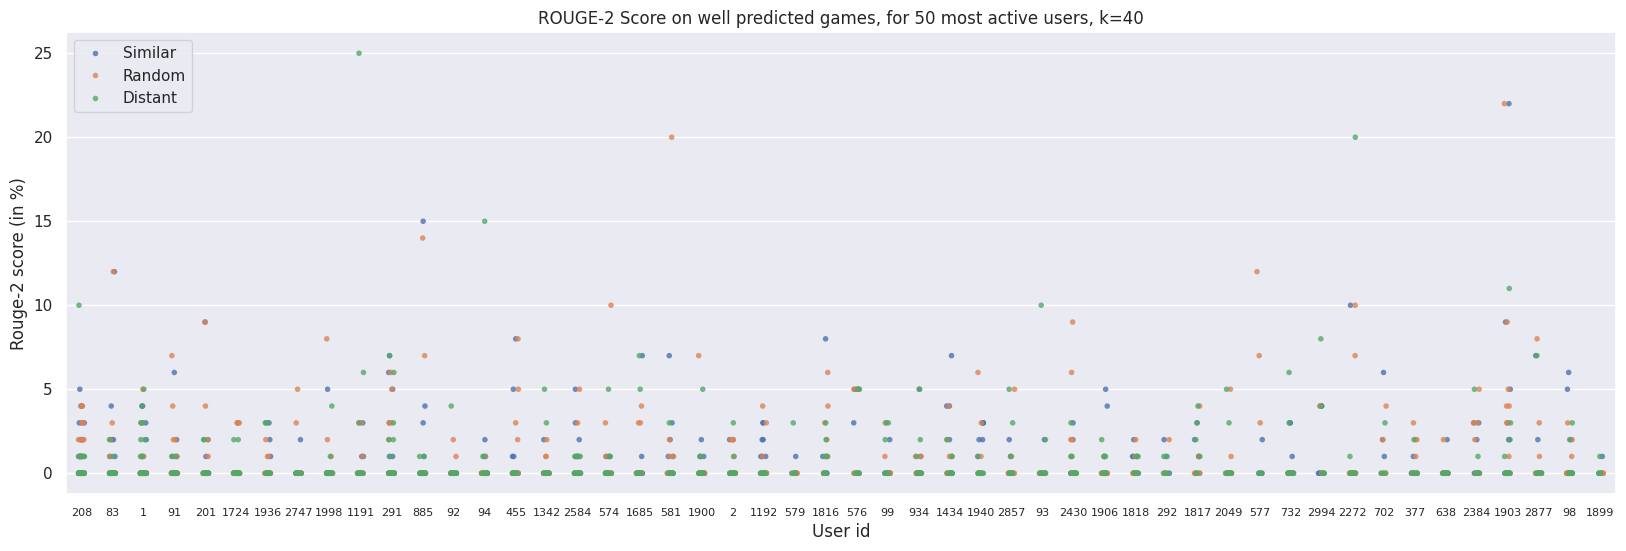

In [356]:
plt.figure(figsize=(20, 6))

np.random.seed(1)
chosen = np.random.choice(top_users[:50], 50, replace=False)

chosen_df = scores_all[scores_all['User id'].isin(chosen)]
chosen_df['User id'] = chosen_df['User id'].astype(str)
chosen_df[['Similar', 'Random', 'Distant']] = chosen_df[['Similar', 'Random', 'Distant']].astype(int)

df_melted = chosen_df.melt(
    id_vars='User id',
    value_vars=['Similar', 'Random', 'Distant'],
    var_name='Type',
    value_name='Score'
)

sns.stripplot(data=df_melted, x='User id', y='Score', hue="Type", s=4, alpha=0.8)

plt.xticks(fontsize=8)
plt.xlabel('User id')
plt.ylabel('Rouge-2 score (in %)')
plt.title('ROUGE-2 Score on well predicted games, for 50 most active users, k=40')
plt.legend()

plt.savefig("ROUGE2_most_active_annexe.svg")
plt.show()

In [661]:
l200 = []
users_kept = []

np.random.seed(1)
random_users = np.random.choice(users_keeps, size=200, replace=False)

for id in random_users:
    res = bev.knn_ROUGE(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
    if res[0] is not None:
        l200.append(res[0]) 
        users_kept.append(id)
    

In [662]:
# Create DataFrame
df200 = pd.DataFrame(l200, columns=['Similar', 'Random', 'Distant'])
df200.insert(0, 'User id', users_kept)
df200.set_index("User id")

,Similar,Random,Distant
User id,,,
3001,0.000000,0.000000,0.000000
1928,0.000000,0.000000,0.000000
577,0.003472,0.006944,0.010417
789,0.040816,0.031746,0.000000
8018,0.000000,0.000000,0.000000
...,...,...,...
3077,0.010929,0.004882,0.017930
3438,0.000000,0.000000,0.000000
2244,0.032613,0.027735,0.018211


In [663]:
l50 = []
np.random.seed(1)
for id in top_users[:50]:
    res = bev.knn_ROUGE(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0.13, k = 40, topx = 150)
    if res[0] is not None:
        l50.append(res[0]) 

In [664]:
# Create DataFrame
df50 = pd.DataFrame(l50, columns=['Similar', 'Random', 'Distant'])
df50.insert(0, 'User id', top_users[:50])

In [665]:
df200[['Random', 'Similar', 'Distant']].mean(), df50[['Random', 'Similar', 'Distant']].mean()

(Random     0.008872
 Similar    0.009193
 Distant    0.010271
 dtype: float64,
 Random     0.011507
 Similar    0.009394
 Distant    0.008055
 dtype: float64)

In [666]:
df200['Type'] = '200 Random users'

In [667]:
df50['Type'] = '50 Most active users'

In [668]:
concat = pd.concat([df200, df50])
concat[['Similar', 'Random', 'Distant']] *= 100
concat

,User id,Similar,Random,Distant,Type
0,3001,0.000000,0.000000,0.000000,200 Random users
1,1928,0.000000,0.000000,0.000000,200 Random users
2,577,0.347222,0.694444,1.041667,200 Random users
3,789,4.081633,3.174603,0.000000,200 Random users
4,8018,0.000000,0.000000,0.000000,200 Random users
...,...,...,...,...,...
45,2384,1.047646,1.732943,0.764007,50 Most active users
46,1903,3.009028,3.649985,1.245092,50 Most active users
47,2877,1.293573,1.677725,1.035096,50 Most active users
48,98,1.434620,0.749434,0.495430,50 Most active users


In [669]:
df_melted_concat = concat.melt(id_vars=['User id', 'Type'], value_vars=['Similar', 'Random', 'Distant'],
                    var_name='Category', value_name='Value')

df_melted_concat['Category'] = pd.Categorical(
    df_melted_concat['Category'],
    categories=['Distant', 'Random', 'Similar'],
    ordered=True
)

mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()
mean_values, df_melted_concat

/tmp/ipykernel_77591/2225781141.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()


(                   Type Category     Value
 0      200 Random users  Distant  1.027139
 1      200 Random users   Random  0.887190
 2      200 Random users  Similar  0.919326
 3  50 Most active users  Distant  0.805452
 4  50 Most active users   Random  1.150664
 5  50 Most active users  Similar  0.939369,
      User id                  Type Category     Value
 0       3001      200 Random users  Similar  0.000000
 1       1928      200 Random users  Similar  0.000000
 2        577      200 Random users  Similar  0.347222
 3        789      200 Random users  Similar  4.081633
 4       8018      200 Random users  Similar  0.000000
 ..       ...                   ...      ...       ...
 544     2384  50 Most active users  Distant  0.764007
 545     1903  50 Most active users  Distant  1.245092
 546     2877  50 Most active users  Distant  1.035096
 547       98  50 Most active users  Distant  0.495430
 548     1899  50 Most active users  Distant  0.384615
 
 [549 rows x 4 columns])

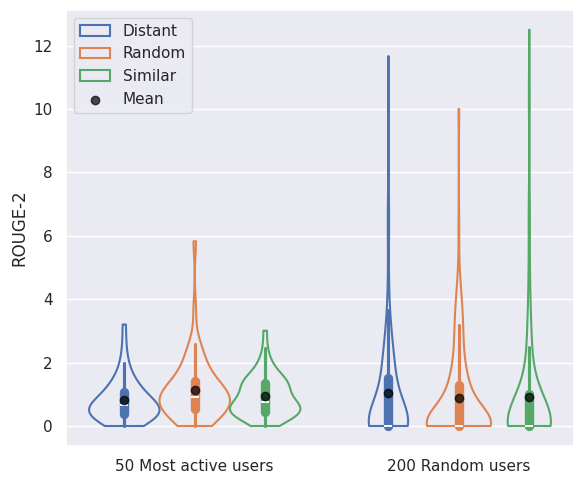

In [670]:
ax = sns.violinplot(data=df_melted_concat, x='Type', y='Value', hue='Category', inner='box', fill=False, cut=0, order=['50 Most active users', '200 Random users'])

offset = 0.267
xticks = ax.get_xticks()
category_offsets = {'Similar': offset, 'Random': 0, 'Distant': -offset}
type_to_x = {
    '50 Most active users': 0,  
    '200 Random users': 1       
}

for _, row in mean_values.iterrows():
    base_x = type_to_x[row['Type']]
    offset = category_offsets[row['Category']]
    x_pos = base_x + offset
    plt.scatter(x_pos, row['Value'], color='black', zorder=10, label='Mean' if _ == 0 else None, alpha=0.7)


# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("ROUGE-2")
plt.xlabel("")

plt.tight_layout()
plt.savefig("vp_thd_top150.svg")
plt.show()


In [37]:
bev.knn_ROUGE(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0, k = 40, topx = None)

(array([0.02787814, 0.02224797, 0.02839074]),
 array([27.24000774, 26.00768974, 27.04261704]))

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
# lemmatized comments
all_doc = filtered_rev_df['Comment']
vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=5, max_df=0.8) # bigrams
vectors_unig = vectorizer.fit_transform(all_doc)
unig_ens = vectorizer.get_feature_names_out()

In [42]:
test = []
test_r = []
test_b = []

np.random.seed(1)
for id in top_users[:50]:
    # res = bev.knn_ROUGE12(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, vectors_unig, unig_ens, threshold = 0.13, k = 40, topx = 150)
    res = bev.knn_ROUGE_prim(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = -1, k = 40, topx = None)  
    if res is not None:
        test.append(res[0])
        test_r.append(res[1])
        test_b.append(res[2]) 

1903 498
1903 918
1903 1058
1903 1607
1903 1752
1903 2164
1903 2594
1903 3595
1903 3897
1903 5625
1903 7854
1903 8428
1903 8533
1903 9270
1903 9727


In [43]:
test2 = []
test_r2 = []
test_b2 = []
users_kept = []

np.random.seed(1)
random_users = np.random.choice(users_keeps, size=200, replace=False)

for id in random_users:
    # res = bev.knn_ROUGE12(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, vectors_unig, unig_ens, threshold = 0.13, k = 40, topx = 150)
    res = bev.knn_ROUGE_prim(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = -1, k = 40, topx = None)  
    if res[0] is not None:
        test2.append(res[0])
        test_r2.append(res[1]) 
        test_b2.append(res[2])
        users_kept.append(id)

In [49]:
# Create DataFrame FOR ROUGE2
test_df = pd.DataFrame(test_r2, columns=['Similar users', 'Random users', 'Distant users'])
test_df.insert(0, 'User id', users_kept)
test_df['Type'] = '200 Random users'

test_dfr1 = pd.DataFrame(test_r, columns=['Similar users', 'Random users', 'Distant users'])
test_dfr1.insert(0, 'User id', top_users[:50])
test_dfr1['Type'] = '50 Most active users'

concat_r1 = pd.concat([test_df, test_dfr1])
concat_r1

df_melted_concat = concat_r1.melt(id_vars=['User id', 'Type'], value_vars=['Similar users', 'Random users', 'Distant users'],
                    var_name='Category', value_name='Value')

df_melted_concat['Category'] = pd.Categorical(
    df_melted_concat['Category'],
    categories=[ 'Similar users', 'Random users', 'Distant users'],
    ordered=True
)
df_melted_concat['Value'] = df_melted_concat['Value'] 

mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()

/tmp/ipykernel_8244/1833758219.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()


In [48]:
# rouge 2
df_melted_r2 = df_melted_concat
mean_val_r2 = mean_values

In [50]:
# rouge1
df_melted_r1 = df_melted_concat
mean_val_r1 = mean_values

In [45]:
# bleu
df_melted_b = df_melted_concat
mean_val_b = mean_values

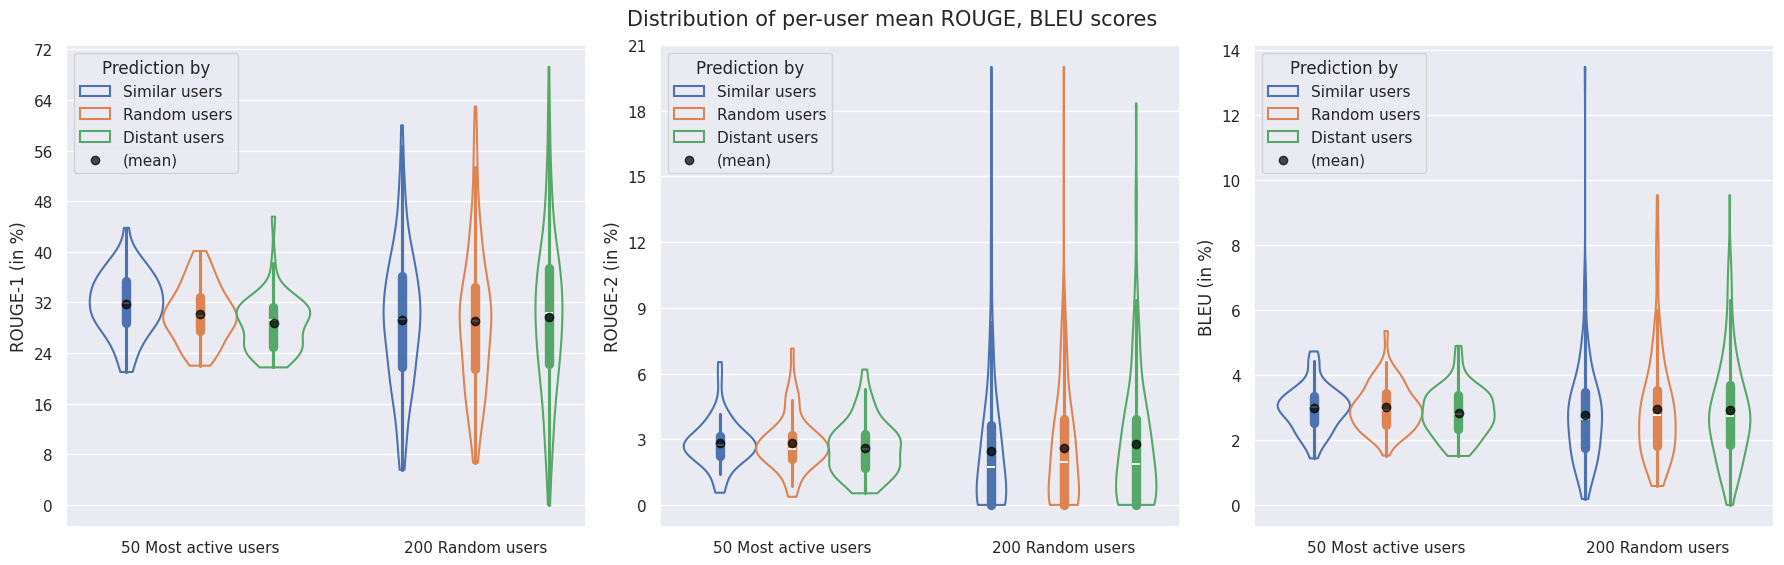

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 3 subplots
fig.suptitle("Distribution of per-user mean ROUGE, BLEU scores", fontsize=15, y=0.94)

offset = 0.267
category_offsets = {'Similar users': -offset, 'Random users': 0, 'Distant users': offset}
type_to_x = {'50 Most active users': 0, '200 Random users': 1}

def plot_violin(ax, data, mean_vals, title, ylabel):
    sns.violinplot(data=data, x='Type', y='Value', hue='Category',
                   inner='box', fill=False, cut=0,
                   order=['50 Most active users', '200 Random users'],
                   ax=ax)
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    for i, row in mean_vals.iterrows():
        base_x = type_to_x[row['Type']]
        offset = category_offsets[row['Category']]
        x_pos = base_x + offset
        ax.scatter(x_pos, row['Value'], color='black', zorder=10,
                   label='(mean)' if i == 0 else None, alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Prediction by", loc='upper left')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")

# ROUGE-1
plot_violin(axs[0], df_melted_r1, mean_val_r1, "", "ROUGE-1 (in %)")

# ROUGE-2
plot_violin(axs[1], df_melted_r2, mean_val_r2, "", "ROUGE-2 (in %)")

plot_violin(axs[2], df_melted_b, mean_val_b, "", "BLEU (in %)")
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("VP_NOtfidf_NOtopx_RB.svg", format='svg')
plt.show()


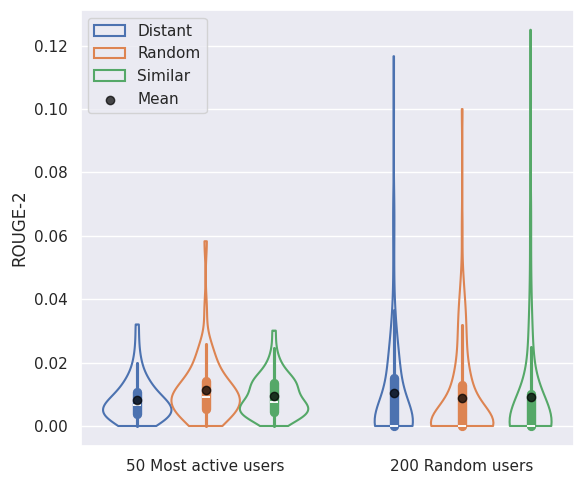

In [60]:
ax = sns.violinplot(data=df_melted_concat, x='Type', y='Value', hue='Category', inner='box', fill=False, cut=0, order=['50 Most active users', '200 Random users'])

offset = 0.267
xticks = ax.get_xticks()

category_offsets = {'Similar': offset, 'Random': 0, 'Distant': -offset}
type_to_x = {
    '50 Most active users': 0,  
    '200 Random users': 1       
}

for _, row in mean_values.iterrows():
    base_x = type_to_x[row['Type']]
    offset = category_offsets[row['Category']]
    x_pos = base_x + offset
    plt.scatter(x_pos, row['Value'], color='black', zorder=10, label='Mean' if _ == 0 else None, alpha=0.7)


# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("ROUGE-2")
plt.xlabel("")

plt.tight_layout()
# plt.savefig("vp_thd_NOtop_ROUGE2.svg")
plt.show()


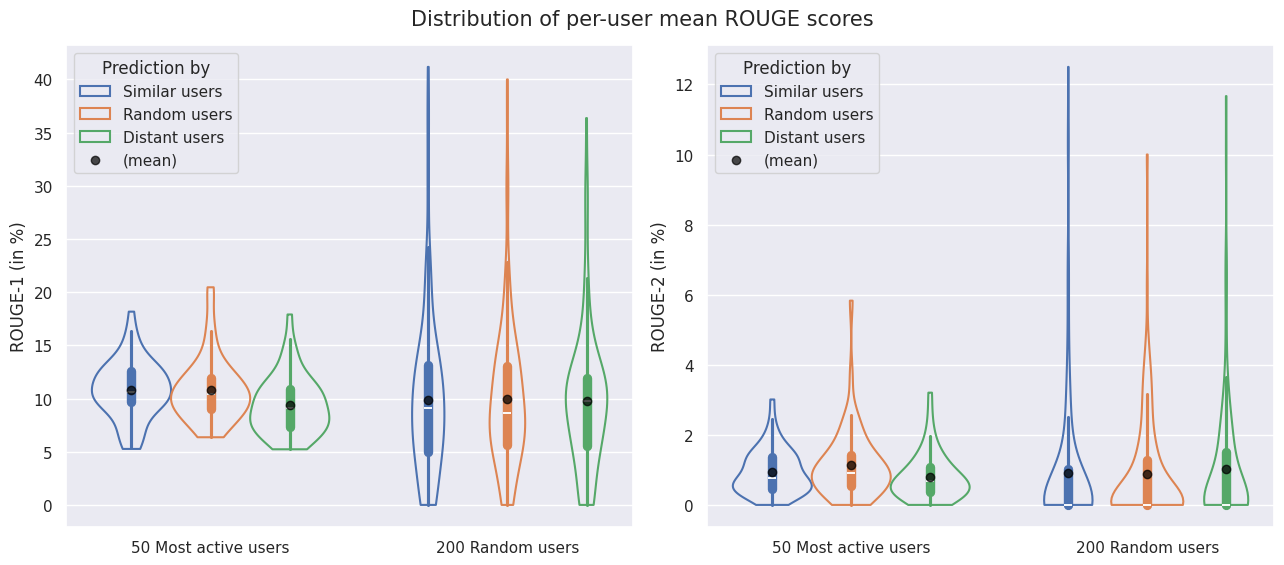

In [491]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(13, 6))  # 3 subplots
fig.suptitle("Distribution of per-user mean ROUGE scores", fontsize=15, y=0.94)

offset = 0.267
category_offsets = {'Similar users': -offset, 'Random users': 0, 'Distant users': offset}
type_to_x = {'50 Most active users': 0, '200 Random users': 1}

def plot_violin(ax, data, mean_vals, title, ylabel):
    sns.violinplot(data=data, x='Type', y='Value', hue='Category',
                   inner='box', fill=False, cut=0,
                   order=['50 Most active users', '200 Random users'],
                   ax=ax)
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    for i, row in mean_vals.iterrows():
        base_x = type_to_x[row['Type']]
        offset = category_offsets[row['Category']]
        x_pos = base_x + offset
        ax.scatter(x_pos, row['Value'], color='black', zorder=10,
                   label='(mean)' if i == 0 else None, alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Prediction by", loc='upper left')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")

# ROUGE-1
plot_violin(axs[0], df_melted_r1, mean_val_r1, "", "ROUGE-1 (in %)")

# ROUGE-2
plot_violin(axs[1], df_melted_r2, mean_val_r2, "", "ROUGE-2 (in %)")

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("VP_tfidf_topx_rouges.svg", format='svg')
plt.show()


In [193]:
# Create DataFrame
test_df_r2 = pd.DataFrame(test_r2, columns=['Similar', 'Random', 'Distant'])
test_df_r2.insert(0, 'User id', users_kept)
test_df_r2.set_index("User id")

,Similar,Random,Distant
User id,,,
3001,36.363636,45.454545,9.090909
1928,36.363636,45.454545,27.272727
577,36.332152,35.854104,28.470038
789,28.054802,33.131075,25.414268
8018,50.000000,50.000000,50.000000
...,...,...,...
3077,32.330460,34.238015,36.692330
3438,28.571429,28.571429,14.285714
2244,37.829648,31.752764,26.038698


In [194]:
test_df_r2['Type'] = '200 Random users'

In [195]:
# Create DataFrame
test_df = pd.DataFrame(test, columns=['Similar', 'Random', 'Distant'])
test_df.insert(0, 'User id', top_users[:50])

In [196]:
test_df_r = pd.DataFrame(test_r, columns=['Similar', 'Random', 'Distant'])
test_df_r.insert(0, 'User id', top_users[:50])

In [197]:
test_df_r['Type'] = '50 Most active users'

In [198]:
concat_r = pd.concat([test_df_r, test_df_r2])
concat_r

,User id,Similar,Random,Distant,Type
0,208,10.433739,9.203833,8.125711,50 Most active users
1,83,9.809974,8.502796,6.984602,50 Most active users
2,1,9.675197,8.850545,6.773020,50 Most active users
3,91,7.142408,9.701476,7.491285,50 Most active users
4,201,11.323307,9.896280,9.457655,50 Most active users
...,...,...,...,...,...
128,3077,32.330460,34.238015,36.692330,200 Random users
129,3438,28.571429,28.571429,14.285714,200 Random users
130,2244,37.829648,31.752764,26.038698,200 Random users
131,636,41.666667,29.166667,29.166667,200 Random users


In [199]:
df_melted_concat = concat_r.melt(id_vars=['User id', 'Type'], value_vars=['Similar', 'Random', 'Distant'],
                    var_name='Category', value_name='Value')

df_melted_concat['Category'] = pd.Categorical(
    df_melted_concat['Category'],
    categories=['Distant', 'Random', 'Similar'],
    ordered=True
)

mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()
mean_values, df_melted_concat

/tmp/ipykernel_5190/3530574429.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()


(                   Type Category      Value
 0      200 Random users  Distant  29.663070
 1      200 Random users   Random  29.067262
 2      200 Random users  Similar  29.252111
 3  50 Most active users  Distant   9.360658
 4  50 Most active users   Random  10.847929
 5  50 Most active users  Similar  10.812634,
      User id                  Type Category      Value
 0        208  50 Most active users  Similar  10.433739
 1         83  50 Most active users  Similar   9.809974
 2          1  50 Most active users  Similar   9.675197
 3         91  50 Most active users  Similar   7.142408
 4        201  50 Most active users  Similar  11.323307
 ..       ...                   ...      ...        ...
 544     3077      200 Random users  Distant  36.692330
 545     3438      200 Random users  Distant  14.285714
 546     2244      200 Random users  Distant  26.038698
 547      636      200 Random users  Distant  29.166667
 548     3435      200 Random users  Distant  43.750000
 
 [549 rows

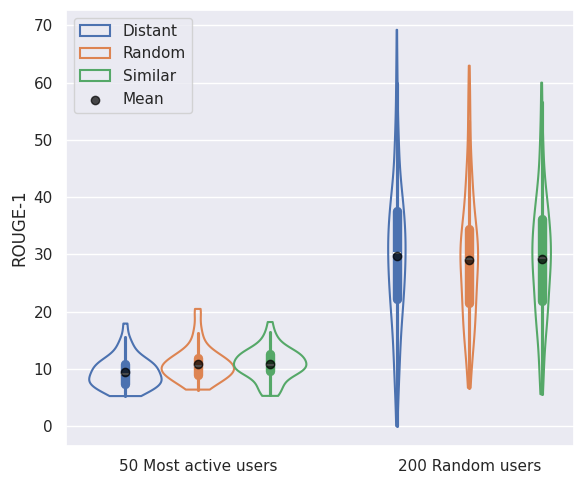

In [201]:
ax = sns.violinplot(data=df_melted_concat, x='Type', y='Value', hue='Category', inner='box', fill=False, cut=0, order=['50 Most active users', '200 Random users'])

offset = 0.267
xticks = ax.get_xticks()
category_offsets = {'Similar': offset, 'Random': 0, 'Distant': -offset}
type_to_x = {
    '50 Most active users': 0,  
    '200 Random users': 1       
}

for _, row in mean_values.iterrows():
    base_x = type_to_x[row['Type']]
    offset = category_offsets[row['Category']]
    x_pos = base_x + offset
    plt.scatter(x_pos, row['Value'], color='black', zorder=10, label='Mean' if _ == 0 else None, alpha=0.7)


# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("ROUGE-1")
plt.xlabel("")

plt.tight_layout()
plt.savefig("vp_thd_top_ROUGE1.svg")
plt.show()


In [631]:
concat_r.groupby("Type").mean()

,User id,Similar,Random,Distant
Type,,,,
200 Random users,2604.090226,29.252111,29.067262,29.663070
50 Most active users,1199.000000,31.819382,30.228154,28.691321


Test TOPX ROUGE 2

In [31]:
# no tf idf

lst_topx = []
lst_topx_r = []

np.random.seed(1)
for k in range(1, 300):
    print(k)
    lst = []
    lst_r = []
    for id in top_users[:50]:
        res = bev.knn_ROUGE(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = -1, k = 40, topx = k)
        if res is not None:
            lst.append(res[0])
            lst_r.append(res[1]) 
    lst_topx.append(np.mean(lst))
    lst_topx_r.append(np.mean(lst_r))

1
2
3
4


/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


5
6
7
8
9
10
11


/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


KeyboardInterrupt: 

In [32]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np

lst_topx = []
lst_topx_r = []
kkeep = []

np.random.seed(1)
# random_users = np.random.choice(users_keeps, size=200, replace=False)
def process_user(id_k):
    id, k = id_k
    res = bev.knn_ROUGE(
        id, matrix_ratings, mask_ratings, cos_sim_matrix,
        users_table, games_table, comments_all, vectors, bigrams_ens,
        threshold=-1, k=40, topx=k
    )
    return res if res is not None else (None, None)

num_workers = 9  # Or use os.cpu_count()

for k in range(1, 301, 5):
    print(k)
    lst = []
    lst_r = []

    args = [(id, k) for id in top_users[:50]]

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = executor.map(process_user, args)

    for res0, res1 in results:
        if res0 is not None:
            lst.append(res0)
            lst_r.append(res1)

    lst_topx.append(np.mean(lst, axis=0))
    lst_topx_r.append(np.mean(lst_r, axis=0))


1
6
11
16
21
26
31


/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


36
41
46
51
56
61
66
71
76
81
86
91
96
101
106
111
116
121
126
131
136
141
146
151
156
161
166
171


KeyboardInterrupt: 

In [29]:
np.array(lst_topx)[:,0]

array([0.00134507, 0.00175538, 0.00234153, 0.00308217, 0.00544685,
       0.00431504, 0.00511408, 0.00741954, 0.00773452, 0.00722368,
       0.00886111, 0.00808742, 0.00867779, 0.00907872, 0.00931216,
       0.01001712, 0.01120273, 0.0100374 , 0.01023985, 0.01097591,
       0.01053002, 0.00824311, 0.01006052, 0.01084579, 0.01047451,
       0.01045883, 0.01081063, 0.01056591, 0.00961428, 0.00924927,
       0.01195631, 0.01209199, 0.01090875, 0.01002985, 0.01198762,
       0.01011536, 0.00938161, 0.01142491, 0.01207999, 0.01097035,
       0.01207021, 0.00941847, 0.00793402, 0.0110969 , 0.01080887,
       0.01213044, 0.01187776, 0.0101479 , 0.01079979, 0.01033075,
       0.01100856, 0.01078135, 0.00895229, 0.00919138, 0.01031879,
       0.01131278, 0.01022185, 0.00957362, 0.01083559, 0.01178035])

In [28]:
# rouge 2 only
lst_topx_200 = lst_topx

In [ ]:
# rouge 2 only
lst_topx_50 = lst_topx

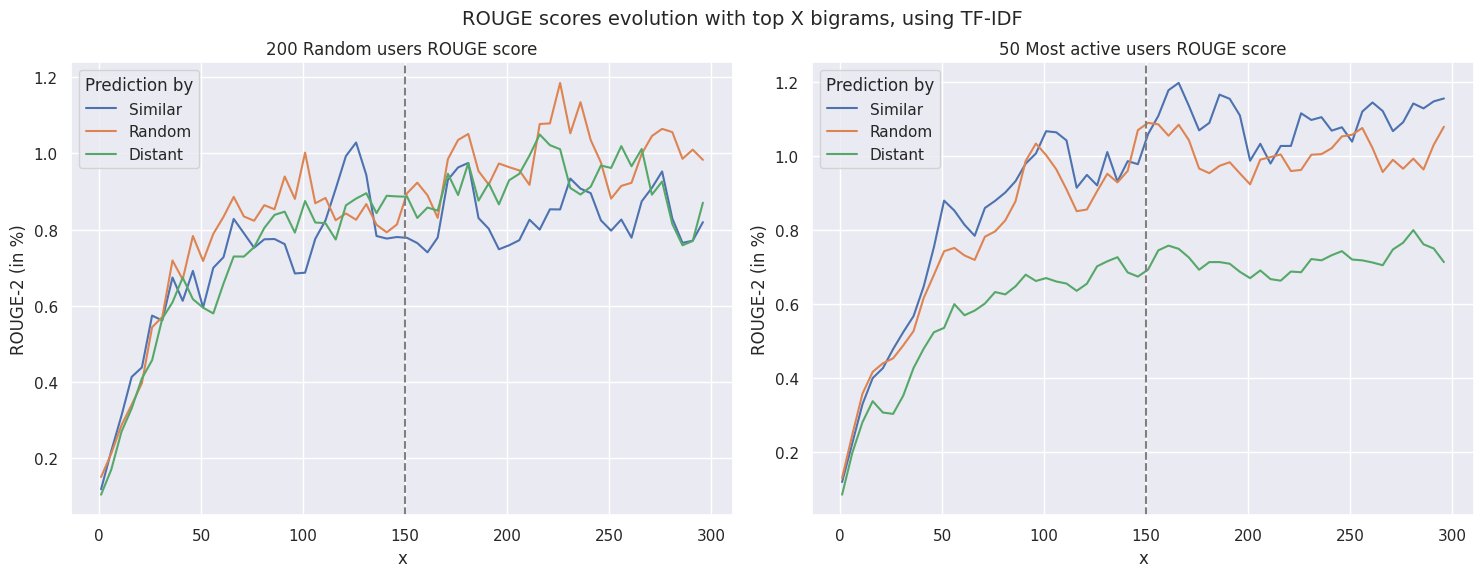

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.ndimage import uniform_filter1d  

palette = sns.color_palette("deep")
colors = {"Similar": palette[0], "Random": palette[1], "Distant": palette[2]}
x = range(1, 300, 5)

data_sets = [
    (lst_topx_200, "200 Random users ROUGE score"),
    (lst_topx_50, "50 Most active users ROUGE score"),
]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("ROUGE scores evolution with top X bigrams, using TF-IDF", fontsize=14, y=0.96)

for ax, (data, title) in zip(axs, data_sets):
    data = np.array(data) * 100
    for idx, label in enumerate(["Similar", "Random", "Distant"]):
        smoothed = uniform_filter1d(data[:, idx], size=3) 
        ax.plot(x, smoothed, c=colors[label], label=label)
    ax.axvline(x=150, color='gray', linestyle='--')
    ax.set_xlabel("x")
    ax.set_ylabel("ROUGE-2 (in %)")
    ax.set_title(title)
    ax.legend(title="Prediction by")

plt.savefig("Courbe_topx.svg", format='svg')
plt.tight_layout()
plt.show()


In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
# lemmatized comments
all_doc = filtered_rev_df['Comment']
vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=5, max_df=0.8) # bigrams
vectors_unig = vectorizer.fit_transform(all_doc)
unig_ens = vectorizer.get_feature_names_out()

In [151]:
np.random.seed(1)
bev.knn_ROUGE12(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, vectors_unig,unig_ens , threshold = 0, k = 40, topx = None)

(array([0.02605077, 0.02498015, 0.01801486]),
 array([28.90995819, 24.85144585, 24.21025073]))

In [93]:
np.random.seed(1)
bev.knn_ROUGE12(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, vectors_unig,unig_ens, threshold = 0.13, k = 40, topx = None)

(array([0.01025792, 0.00853714, 0.00477376]),
 array([10.43373931,  9.20383304,  8.12571116]))

In [248]:
from sacrebleu import BLEU

bleu = BLEU(max_ngram_order=1,effective_order=True)
bleu.sentence_score(hypothesis="je suis la je suis la", references=["je suis la"]).score

49.99999999999999

In [218]:
bev.knn_ROUGE_prim(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0, k = 40, topx = None)

(array([0.02631884, 0.02525014, 0.01906139]),
 array([31.36191557, 28.60453546, 27.08933891]),
 array([0.07560309, 0.02792718, 0.04040184]))

In [267]:
test = []
test_r = []
test_b = []

np.random.seed(1)
for id in top_users[:50]:
    res = bev.knn_ROUGE_prim(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0, k = 40, topx = None)
    if res is not None:
        test.append(res[0])
        test_r.append(res[1]) 
        test_b.append(res[2])

In [268]:
test2 = []
test_r2 = []
test_b2 = []
users_kept = []

np.random.seed(1)
random_users = np.random.choice(users_keeps, size=200, replace=False)

for id in random_users:
    res = bev.knn_ROUGE_prim(id, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0, k = 40, topx = None)
    if res[0] is not None:
        test2.append(res[0])
        test_r2.append(res[1]) 
        test_b2.append(res[2])
        users_kept.append(id)

In [274]:
# Create DataFrame FOR ROUGE2
test_df = pd.DataFrame(test2, columns=['Similar', 'Random', 'Distant'])
test_df.insert(0, 'User id', users_kept)
test_df['Type'] = '200 Random users'

test_dfr1 = pd.DataFrame(test, columns=['Similar', 'Random', 'Distant'])
test_dfr1.insert(0, 'User id', top_users[:50])
test_dfr1['Type'] = '50 Most active users'

concat_r1 = pd.concat([test_df, test_dfr1])
concat_r1

df_melted_concat = concat_r1.melt(id_vars=['User id', 'Type'], value_vars=['Similar', 'Random', 'Distant'],
                    var_name='Category', value_name='Value')

df_melted_concat['Category'] = pd.Categorical(
    df_melted_concat['Category'],
    categories=['Distant', 'Random', 'Similar'],
    ordered=True
)

mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()

/tmp/ipykernel_5190/2361575489.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_melted_concat.groupby(['Type', 'Category'])['Value'].mean().reset_index()


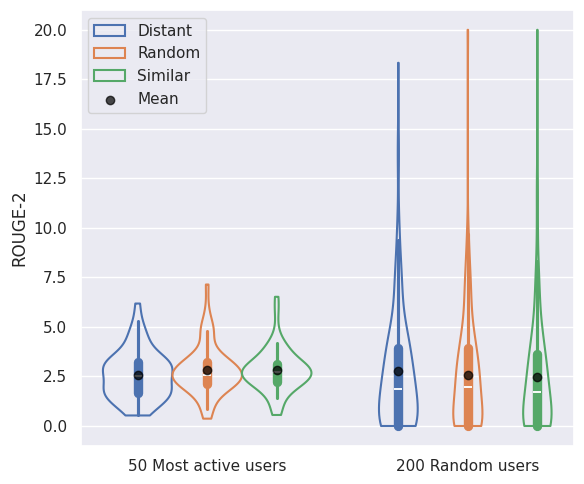

In [275]:
ax = sns.violinplot(data=df_melted_concat, x='Type', y='Value', hue='Category', inner='box', fill=False, cut=0, order=['50 Most active users', '200 Random users'])

offset = 0.267
xticks = ax.get_xticks()
category_offsets = {'Similar': offset, 'Random': 0, 'Distant': -offset}
type_to_x = {
    '50 Most active users': 0,  
    '200 Random users': 1       
}

for _, row in mean_values.iterrows():
    base_x = type_to_x[row['Type']]
    offset = category_offsets[row['Category']]
    x_pos = base_x + offset
    plt.scatter(x_pos, row['Value'], color='black', zorder=10, label='Mean' if _ == 0 else None, alpha=0.7)


# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("ROUGE-2")
plt.xlabel("")

plt.tight_layout()
plt.savefig("vp_NOthd_NOtop_ROUGE2_last.svg")
plt.show()


In [251]:
np.random.seed(1)
bev.knn_ROUGE12(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, vectors_unig,unig_ens , threshold = 0.13, k = 40, topx = 150)

(array([0.01025792, 0.00853714, 0.00477376]),
 array([10.43373931,  9.20383304,  8.12571116]))

In [254]:
# generate comment user random, best score

users_kept = []
r1 = []
r2 = []

np.random.seed(1)
random_users = np.random.choice(users_keeps, size=200, replace=False)

for id in random_users:
    print("users ",id)
    res = bev.knn_ROUGE12(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, vectors_unig,unig_ens , threshold = 0.13, k = 40, topx = 150)
    if res[0] is not None:
        r1.append(res[0])
        r2.append(res[1])

        users_kept.append(id)

users  6860
max : 9136 23.809523809523807 4278 33.33333333333333 5848 25.806451612903224
users  3001
max : 7677 38.46153846153847 5103 25.0 3711 27.27272727272727
users  1976
max : 805 25.0 6325 28.947368421052634 5926 33.33333333333333
users  1928
max : 5926 25.0 15 20.0 15 40.0
users  577
max : 1305 22.22222222222222 3828 25.0 1305 22.22222222222222
users  601
max : 7426 33.33333333333333 3140 30.0 15 60.0
users  454
max : 1305 22.22222222222222 4265 33.33333333333333 1305 22.22222222222222
users  789
max : 7636 25.0 7636 33.33333333333333 918 26.923076923076923
users  8018
max : 6823 28.57142857142857 8483 39.02439024390244 15 40.0
users  6539
max : 1305 22.22222222222222 1305 25.925925925925924 6696 50.0
users  4556
max : 7426 33.33333333333333 5754 20.0 8449 25.0
users  3768
max : 3038 23.076923076923077 3897 36.36363636363637 512 26.31578947368421
users  3576
max : 9263 29.411764705882355 9612 25.806451612903224 9263 29.411764705882355
users  3368
max : 9612 29.03225806451613 599

In [255]:
import textwrap

long_text = "This is a very long sentence that should be wrapped neatly when printed in a Jupyter Notebook for better readability."

print(textwrap.fill(long_text, width=80))

This is a very long sentence that should be wrapped neatly when printed in a
Jupyter Notebook for better readability.


In [266]:
bev.knn_ROUGE_prim(208, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, vectors, bigrams_ens, threshold = 0, k = 40, topx = None)

simple interactif plutot marrer regle simple theme rigolo mecanique sympa rejouabilite moyen sympa apero rigoler prendre tete regle attendre gagner petit monde valoir arreter peuple disparaitre compter membre point victoire refaire partie coeur dire vif echecs vif service comprendre accord precedent avis ne jouer pas strategie volonte trouver tactique battre jeu simple chance theme sympa etre bien jouer super casser tete place classe jeu enorme succes jouer jeu mome aimer bien theme carte echange cela produit alliance defaire rythme emparer partie commencer service comprendre amener jeu enfant ne jouer pas causer jeu prendre tete adorer ne chance vif echec vif service comprendre
temps temps service comprendre jeu but principal mettre ambiance table aller jouer piocher carte essayer aller embeter sembler bien partir venir crasse jeu fonctionner bien petit groupe adolescent si elimination aller grincer dent vif echecs vif service comprendre accord precedent avis ne jouer pas strategie vo

(array([2.32473993, 2.0984466 , 1.21099741]),
 array([27.6104053 , 25.59699615, 22.27734591]),
 array([2.6439557 , 2.77454647, 2.64801469]))